<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/15_Chemical_DKL_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QM9 SMILES to SELFIES

In this notebook, we explore whether the deep kernel learnign approach gives a better strucutred latent spaces then the VAE. The VAEs buind patent spaces based on the data only. DKL builds latent space based on the feature and target.

Note that DKL can be applied to the whole data set, or can be built as an active experiment where the features (molecular structures) are available all at the same time, and the targets are becoming available sequentially. Thsi both provides a way to guide experimental discovery, and also forms particularly well organized latent spaces.

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The DKL is adapted from the notebooks from Mani Valleti, svalleti@vols.utk.edu
- The GPax is by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- Workflow built by Sergei V. Kalinin

## Install RDkit and Selfies

In [1]:
!pip install rdkit-pypi
!pip install selfies --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch

from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf

Define parser functions

In [3]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

This is the QM9 data set (local copy). Can also be downloaded from original repository.

In [4]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From: https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:01<00:00, 54.6MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [5]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

Here, we select a number of molecules to explore. Currently, 10000 as limited by the Colab memory when DKL is run.

In [6]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])

    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']

    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

In additionan to QM9 descriptors, let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [7]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):

    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [8]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu, 'enthalpy': enthalpy})

In [9]:
df

smiles  mole_logp   tpsa      mol_wt  hbd  hba valencee  \
0          CC(O)C#CC1CCO1    0.15950  29.46  126.068080    1    2    (50,)   
1          CC12CC3OC1C3O2    0.31500  18.46  112.052429    0    2    (44,)   
2     CC12CC1(C=O)C(=O)N2   -0.53610  46.17  125.047678    1    2    (48,)   
3            CCCNCC(=O)OC    0.15900  38.33  131.094629    1    3    (54,)   
4          O=C1NCC(O1)C#N   -0.38162  62.12  112.027277    1    3    (42,)   
...                   ...        ...    ...         ...  ...  ...      ...   
4995      CCN1C=C(CO)C=N1    0.39530  38.05  126.079313    1    3    (50,)   
4996     CC1=CCC2CC1(O)C2    1.47750  20.23  124.088815    1    1    (50,)   
4997    O=C1CN2CC(C#C)C12   -0.49730  20.31  121.052764    0    2    (46,)   
4998     CC#CC(C)(C=O)C#C    0.84810  17.07  120.057515    0    1    (46,)   
4999     CN1C2CC2(O)C1C=O   -0.99730  40.54  127.063329    1    3    (50,)   

      max_partialcharge  min_partialcharge  rotatablebd  ringct  stereocent  \
0              0.120032          -0.380678            0       1           2   
1              0.115443          -0.366237            0       5           4   
2              0.235860          -0.348416            1       2           2   
3              0.319140          -0.468058            4       0           0   
4              0.408187          -0.428878            0       1           1   
...                 ...                ...          ...     ...         ...   
4995           0.071209          -0.391561            2       1           0   
4996           0.085917          -0.385506            0       3           0   
4997           0.164733          -0.296422            0       2           2   
4998           0.149356          -0.300584            1       0           1   
4999           0.139638          -0.386074            1       2           3   

      dipole_moment    enthalpy  
0            1.1136 -422.959950  
1            0.5219 -383.685315  
2            3.4856 -437.887582  
3            1.4496 -441.500803  
4            4.8246 -414.704217  
...             ...         ...  
4995         1.7993 -419.216485  
4996         1.2299 -387.088129  
4997         1.9488 -400.668537  
4998         2.5624 -384.626576  
4999         2.8156 -439.018664  

[5000 rows x 14 columns]

## Convert SMILEs to SELFIEs

In [10]:
# smiles

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [11]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 552: input violates the currently-set semantic constraints
	SMILES: CC1=NC(=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1717: input violates the currently-set semantic constraints
	SMILES: NC1=CNC(=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2753: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=NC=CC=C1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4495: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=NC=CN=N1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]



Let's see what these molecules are....

In [12]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=NC(=NO1)N(=O)=O',
 'NC1=CNC(=N1)N(=O)=O',
 'O=N(=O)C1=NC=CC=C1',
 'O=N(=O)C1=NC=CN=N1'}

... how many of them are there

In [13]:
df['smiles'].isin(error_smiles_set).sum()

4

And remove them from the dataframe

In [14]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

smiles  mole_logp   tpsa      mol_wt  hbd  hba valencee  \
4995    CCN1C=C(CO)C=N1     0.3953  38.05  126.079313    1    3    (50,)   
4996   CC1=CCC2CC1(O)C2     1.4775  20.23  124.088815    1    1    (50,)   
4997  O=C1CN2CC(C#C)C12    -0.4973  20.31  121.052764    0    2    (46,)   
4998   CC#CC(C)(C=O)C#C     0.8481  17.07  120.057515    0    1    (46,)   
4999   CN1C2CC2(O)C1C=O    -0.9973  40.54  127.063329    1    3    (50,)   

      max_partialcharge  min_partialcharge  rotatablebd  ringct  stereocent  \
4995           0.071209          -0.391561            2       1           0   
4996           0.085917          -0.385506            0       3           0   
4997           0.164733          -0.296422            0       2           2   
4998           0.149356          -0.300584            1       0           1   
4999           0.139638          -0.386074            1       2           3   

      dipole_moment    enthalpy  
4995         1.7993 -419.216485  
4996         1.2299 -387.088129  
4997         1.9488 -400.668537  
4998         2.5624 -384.626576  
4999         2.8156 -439.018664

Now, let's generate one-hot encodings.

In [15]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4996, 21, 27)

These one-hot encodings are our primary descriptors. Of course, we can use any other rperesentation - as original SMILES string, as SELFIE string, as ajacency matrix, etc. However, here we explore comparison between the VAE, static DKL, and active DKL, so we stick to one format.

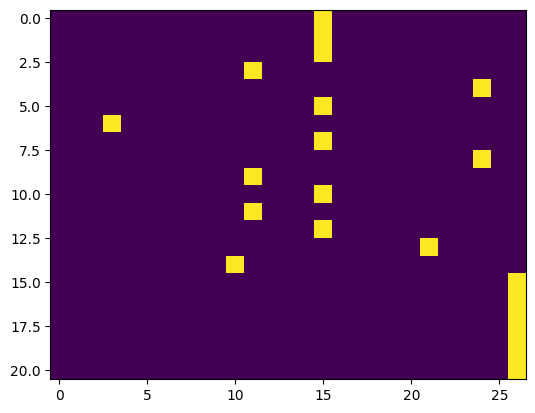

In [16]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

# Simple VAE

Here, we build a simple VAE to explore how the molecular properties are distributed in the 2D latent space.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

This is one-hot encoded molecule object

In [18]:
molecules = np.array(one_hot_vectors)
print(molecules.shape)

(4996, 21, 27)


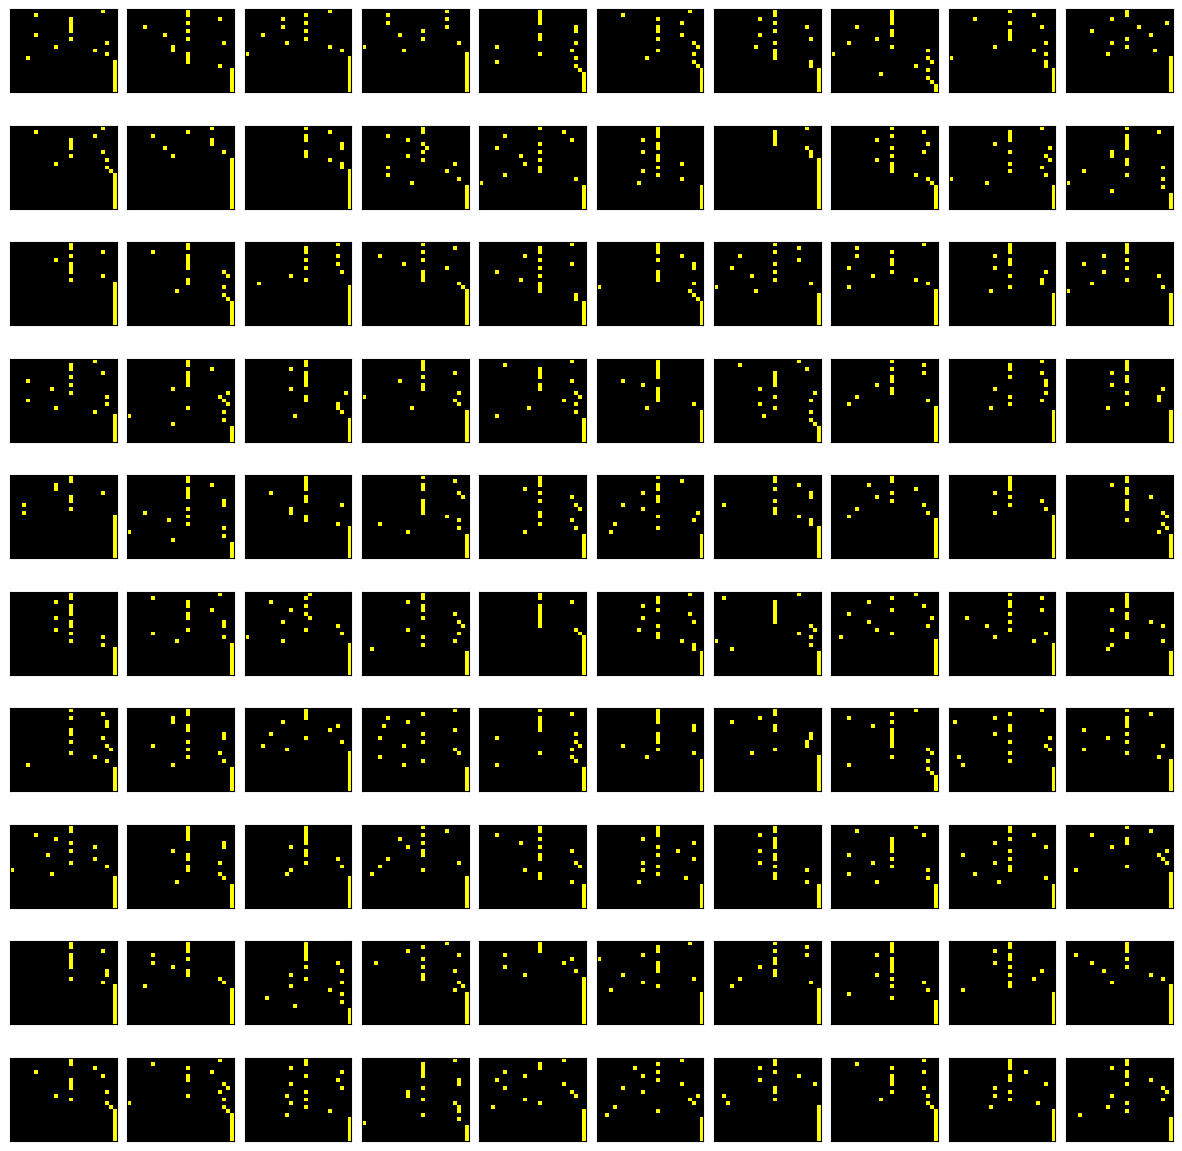

In [19]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(molecules))
    ax.imshow(molecules[i], cmap='gnuplot', interpolation = None)

In [20]:
input_shape = (molecules.shape[1], molecules.shape[2])
original_dim = np.prod(input_shape)
latent_dim = 2

# Encoder
inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(original_dim, activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

# Instantiate models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE Loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [21]:
data = np.array(one_hot_vectors)
vae.fit(data, epochs=100, batch_size=64)

Epoch 1/100
79/79 [==============================] - 6s 4ms/step - loss: 170.2050
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 54.0990
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 48.5359
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 46.3332
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 45.2073
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 44.0019
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 42.5411
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 41.3542
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 40.4608
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 40.0033
Epoch 11/100
79/79 [==============================] - 0s 4ms/step - loss: 39.5887
Epoch 12/100
79/79 [==============================] - 0s 4ms/step - loss: 39.1728
Epoch 13/100
79/79 [====

In [22]:
def plot_latent_representation(decoder, height=21, width=27, n=15):
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    figure = np.zeros((height * n, width * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(height, width)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()


In [23]:
def plot_latent_space(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
    plt.colorbar()
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.title('Latent Space')
    plt.show()


1/1 [==============================] - 0s 20ms/step


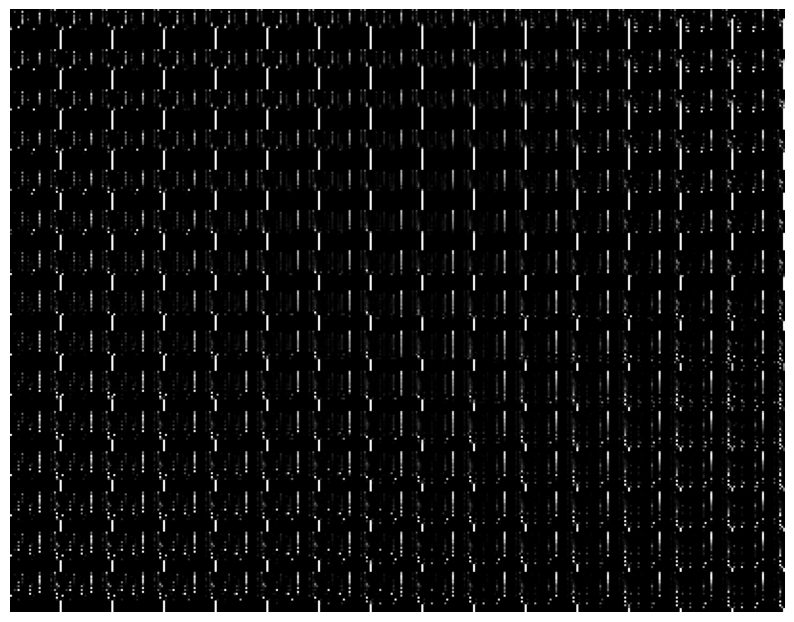

In [24]:
plot_latent_representation(decoder)

In [25]:
# If you would like to plot a single parameter
# plot_latent_space(encoder, data, df_filtered['dipole_moment'].values)

157/157 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Max Partial Charge')

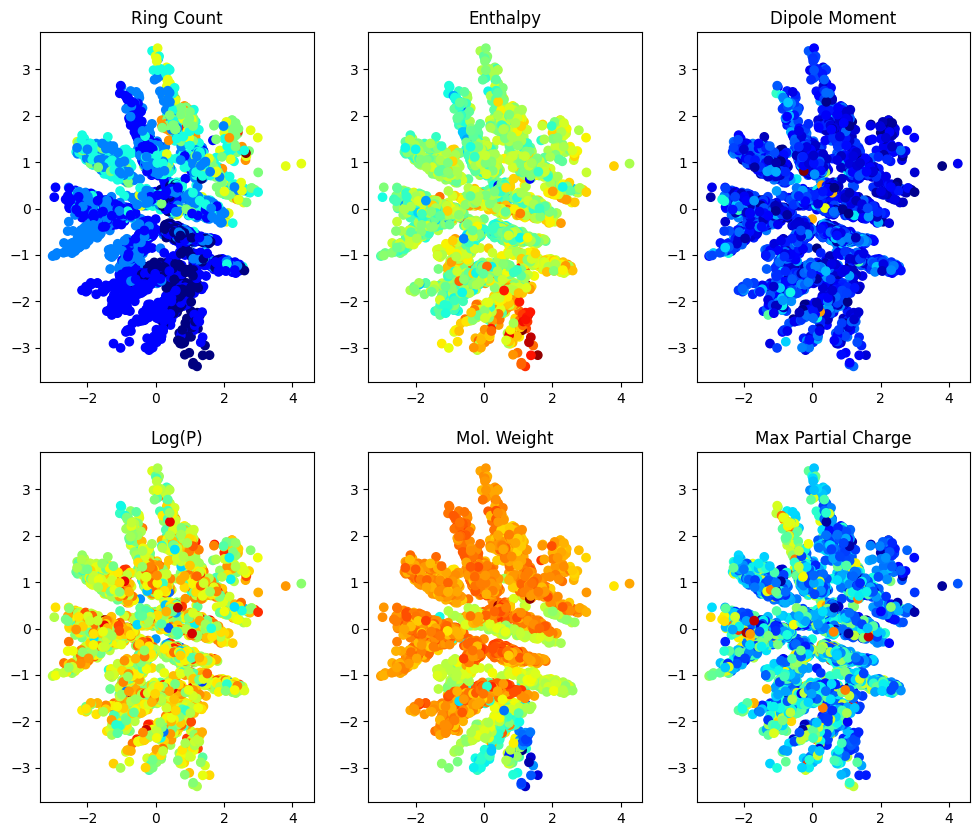

In [26]:
z_mean, _, _ = encoder.predict(data)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,10))
ax[0,0].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['ringct'], cmap='jet')
ax[0,0].set_title('Ring Count')
ax[0,1].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['enthalpy'], cmap='jet')
ax[0,1].set_title('Enthalpy')
ax[0,2].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['dipole_moment'], cmap='jet')
ax[0,2].set_title('Dipole Moment')
ax[1,0].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['mole_logp'], cmap='jet')
ax[1,0].set_title('Log(P)')
ax[1,1].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['mol_wt'], cmap='jet')
ax[1,1].set_title('Mol. Weight')
ax[1,2].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['max_partialcharge'], cmap='jet')
ax[1,2].set_title('Max Partial Charge')


Generally, we see that the represnetationsof the data set are disentangled. We see some clear correlations in Ring Count, Enthalpy, Molecular weight. Comparatively very little in Log(P) and Dipole Moment.

# DKL on molecules (2D latent space)

Here we explore the DKL to explore the molecule data set. We want to learn the function f(SELFIES) -> functionality.
- We can run DKL on the full data set to explore embeddings
- Or we can run the DKL as an active learning process - meaning that all the features are available (or equivalently our search space is defined), whereas targets are becoming available sequentially, as would be the case for (expensive) experiments. We should also define several useful variables, namely, the number of initial samples (for active learning), number of exploration steps, batch size for active learning (should be smaller then number of initial samples, or code will not work), and batch size for reconstructions. Parenthetically, batch size can be variable (so we can increase it when samples are becoming available).
- Keep in mind the DKL tries to minimize function. Add minus sign as appropriate

Adapted from notebook made for cards:
- References https://arxiv.org/abs/2303.14554
- Made by Mani Valleti, https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!



In [27]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
import torch
import torch.nn as nn
tt = torch.tensor

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()

import pickle

## DKL on full dataset

If you are curious with this approach, it will be illustrative to run the code several times for different discovery/optimization targets. For example:
- Easy to recognize (number of rings)
- Reasonably systematic one (enthalpy)
- Difficult to recognize (dipole moment)

In [29]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

#Actual target
targets5 = df_filtered['dipole_moment'].values #mole_logp

'''
# Three alternative targets
targets1 = df_filtered['mole_logp'].values  #dipole_moment
targets2 = df_filtered['mol_wt'].values
targets3 = df_filtered['dipole_moment'].values
'''

(4996, 567)


"\n# Three alternative targets\ntargets1 = df_filtered['mole_logp'].values  #dipole_moment\ntargets2 = df_filtered['mol_wt'].values\ntargets3 = df_filtered['dipole_moment'].values\n"

In [30]:
X5 = np.copy(X)

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, init loss: 49780.3114, avg. loss [951-1000]: 41922.2013]



Inferred GP kernel parameters
k_length         [0.8913 0.7626]
k_scale          7.0065
noise            0.2053


Now we see the DKL latent space with the Labels correpsonding to the target and several other parameters.

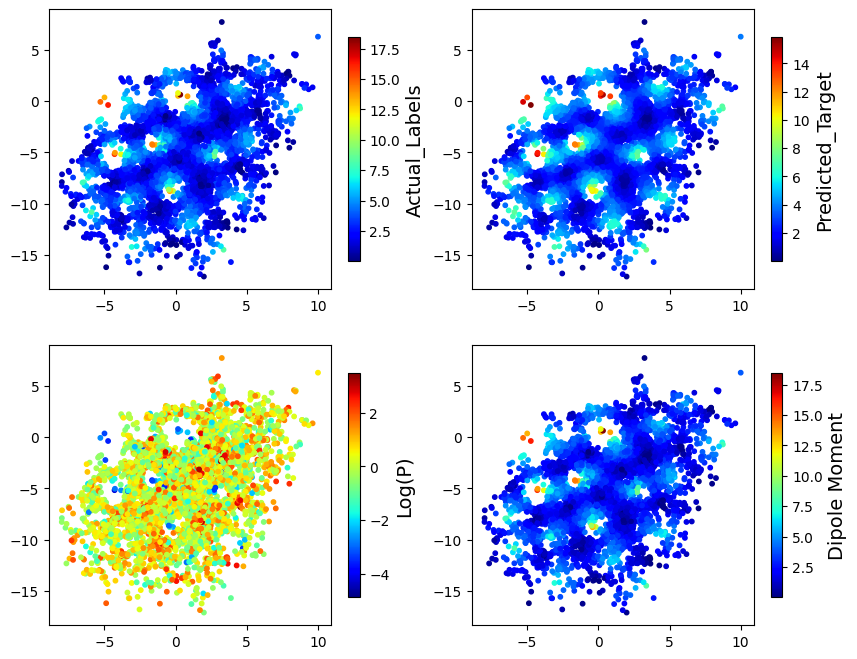

In [31]:
batch_size_reconstruct = 250

embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = targets5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = df_filtered['mole_logp'].values,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = df_filtered['dipole_moment'].values, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Dipole Moment", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Text(0.5, 1.0, 'Dipole Moment')

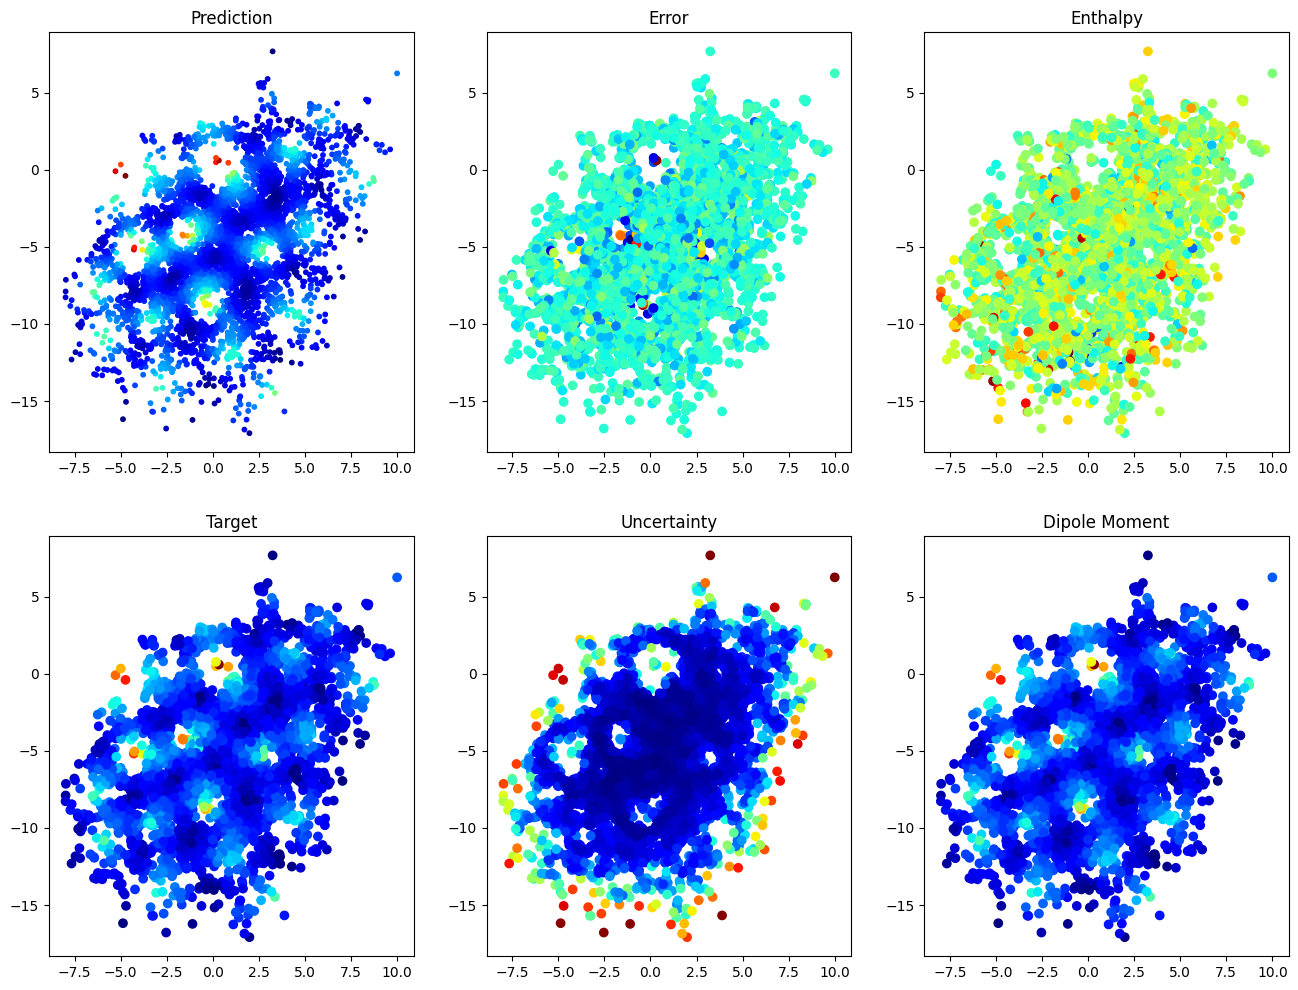

In [32]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,12))
ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap='jet')
ax[0,0].set_title('Prediction')
ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], c = targets5 - pred_mean5, cmap='jet')
ax[0,1].set_title('Error')
ax[0,2].scatter(embeded_5[:, 1], embeded_5[:, 0], c = df_filtered['enthalpy'], cmap='jet')
ax[0,2].set_title('Enthalpy')
ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], c = targets5, cmap='jet')
ax[1,0].set_title('Target')
ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], c = pred_var5, cmap='jet')
ax[1,1].set_title('Uncertainty')
ax[1,2].scatter(embeded_5[:, 1], embeded_5[:, 0], c = df_filtered['dipole_moment'], cmap='jet')
ax[1,2].set_title('Dipole Moment')

This founction finds the 5 maximal points for a parameter we are interested in, and returns corresponding molecular structures

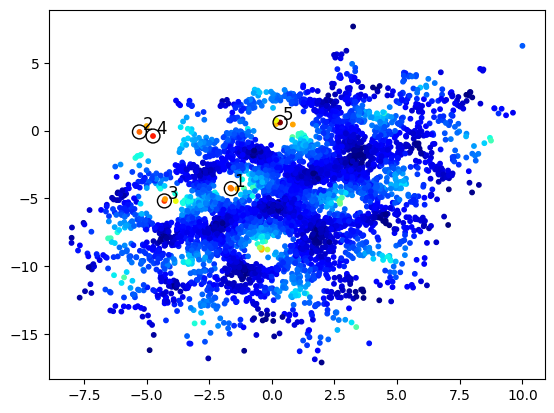

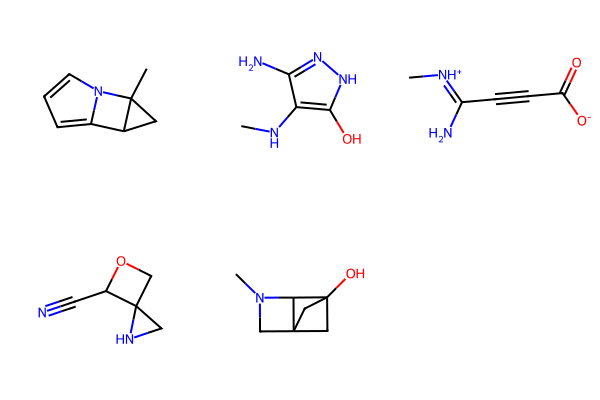

In [33]:
# Find indices of the 5 maximal points in pred_var5

expl_parameter = targets5 # - pred_mean5

max_indices = np.argsort(expl_parameter)[-5:]

# Plot the original scatter plot
plt.scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c=expl_parameter, cmap='jet')

# Plot circles and offset numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_5[idx, 1], embeded_5[idx, 0], s=100, facecolors='none', edgecolors='black')
    # Offset the text slightly from the circle
    plt.text(embeded_5[idx, 1] + 0.12, embeded_5[idx, 0] + 0.18, str(i+1), color='black', fontsize=12)

plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules_2):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules_2, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img


Thsi function allows us to explore points separated by no less then minimal distance

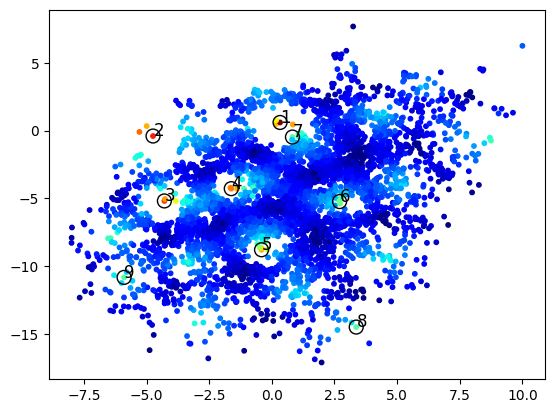

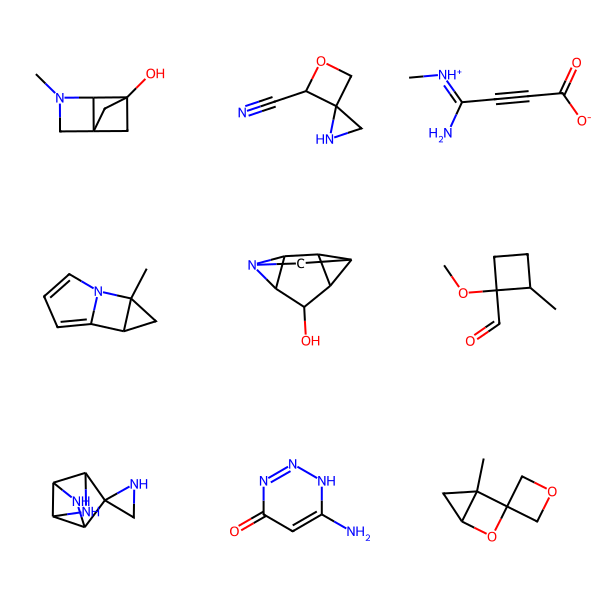

In [34]:
expl_parameter = targets5 #- pred_mean5
min_distance = 1  # Set a minimum distance, adjust as needed

def are_points_separated(point, other_points, min_distance):
    """Check if 'point' is at least 'min_distance' away from all points in 'other_points'."""
    return np.all(np.linalg.norm(other_points - point, axis=1) >= min_distance)

# Sort indices by descending pred_var5 value
sorted_indices = np.argsort(expl_parameter)[::-1]

max_indices = []

for idx in sorted_indices:
    if len(max_indices) >= 9:
        break
    point = embeded_5[idx]
    # Convert max_indices to a numpy array for proper indexing
    if not max_indices or are_points_separated(point, embeded_5[np.array(max_indices)], min_distance):
        max_indices.append(idx)

# Plot the original scatter plot
plt.scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c=expl_parameter, cmap='jet')

# Plot circles and numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_5[idx, 1], embeded_5[idx, 0], s=100, facecolors='none', edgecolors='black')
    plt.text(embeded_5[idx, 1] + 0.01, embeded_5[idx, 0] + 0.01, str(i+1), color='black', fontsize=12)

plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img

And this one selects points close to one of the selected maxima

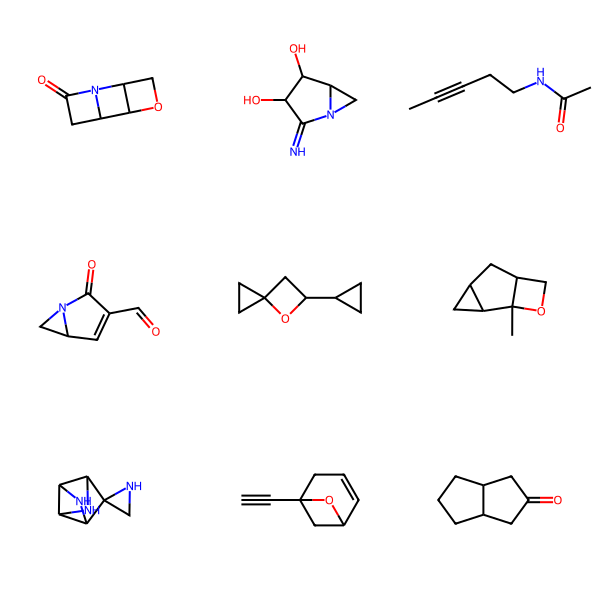

In [35]:
selected_max_idx = max_indices[0]  # Selecting the first maximum for demonstration

def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point], embedding, 'euclidean').flatten()
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]  # Exclude the reference point itself
    return nearest_indices

# Selecting a maximum and finding nearest neighbors
neighbor_indices = find_nearest_neighbors(selected_max_idx, embeded_5)
neighbor_rows = df.iloc[neighbor_indices]
neighbor_smiles = neighbor_rows['smiles'].tolist()
neighbor_molecules = [Chem.MolFromSmiles(smile) for smile in neighbor_smiles]
neighbor_img = Draw.MolsToGridImage(neighbor_molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
neighbor_img

## Active learning

Note that we should be careful withthe target choice selecting the minus sign when appropriate. For example,
- targets5 = - df_filtered['ringct'].values will look for linear molecules
- targets5 = df_filtered['ringct'].values will look for maximal amount of loops

In [36]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

#Actual target
targets5 = df_filtered['dipole_moment'].values #mole_logp dipole_moment

(4996, 567)


In [37]:
init_num = 200
exp_step = 200
batch_size_learn = 10 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

In [38]:
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = init_num, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [39]:
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = exp_step

for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(s2*s3, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])

    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]

    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)

    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=batch_size_learn)

    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)
    traj_std5.append(traj_s)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 343.10it/s, init loss: 39908.0122, avg. loss [951-1000]: 37244.4698]



Inferred GP kernel parameters
k_length         [1.9726 1.6037]
k_scale          9.9161
noise            0.0135

Step 2


100%|██████████| 1000/1000 [00:03<00:00, 331.24it/s, init loss: 39913.5873, avg. loss [951-1000]: 37235.6811]



Inferred GP kernel parameters
k_length         [1.6481 1.964 ]
k_scale          9.9847
noise            0.0128

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 340.07it/s, init loss: 39916.3154, avg. loss [951-1000]: 37722.3565]



Inferred GP kernel parameters
k_length         [0.9928 1.3436]
k_scale          10.7809
noise            0.017

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 344.22it/s, init loss: 39917.8081, avg. loss [951-1000]: 37384.0754]



Inferred GP kernel parameters
k_length         [0.834  1.4584]
k_scale          11.1651
noise            0.0199

Step 5


100%|██████████| 1000/1000 [00:03<00:00, 328.35it/s, init loss: 39919.4628, avg. loss [951-1000]: 37250.4483]



Inferred GP kernel parameters
k_length         [1.4094 1.916 ]
k_scale          10.1425
noise            0.0122

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 336.30it/s, init loss: 39931.0089, avg. loss [951-1000]: 37264.4400]



Inferred GP kernel parameters
k_length         [1.6255 1.6816]
k_scale          10.1433
noise            0.012100000000000001

Step 7


100%|██████████| 1000/1000 [00:03<00:00, 284.61it/s, init loss: 39933.9849, avg. loss [951-1000]: 37283.7706]



Inferred GP kernel parameters
k_length         [1.557  1.6007]
k_scale          9.612
noise            0.0151

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 336.60it/s, init loss: 39935.0723, avg. loss [951-1000]: 37283.1605]



Inferred GP kernel parameters
k_length         [1.3495 1.3508]
k_scale          10.128300000000001
noise            0.012700000000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 354.24it/s, init loss: 39936.1857, avg. loss [951-1000]: 37242.1560]



Inferred GP kernel parameters
k_length         [1.4116 1.9368]
k_scale          10.217
noise            0.0134

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 334.70it/s, init loss: 39937.7176, avg. loss [951-1000]: 37214.7001]



Inferred GP kernel parameters
k_length         [1.7508 1.8329]
k_scale          10.159
noise            0.0108

Step 11


100%|██████████| 1000/1000 [00:03<00:00, 325.75it/s, init loss: 39939.9430, avg. loss [951-1000]: 37252.5015]



Inferred GP kernel parameters
k_length         [1.492  1.8877]
k_scale          9.907300000000001
noise            0.0151

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 338.80it/s, init loss: 39941.9357, avg. loss [951-1000]: 37386.9303]



Inferred GP kernel parameters
k_length         [1.2568 1.357 ]
k_scale          10.439400000000001
noise            0.0143

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 339.10it/s, init loss: 39943.5736, avg. loss [951-1000]: 37259.6179]



Inferred GP kernel parameters
k_length         [1.5579 1.9467]
k_scale          9.952200000000001
noise            0.018600000000000002

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 337.26it/s, init loss: 39944.7830, avg. loss [951-1000]: 37775.8084]



Inferred GP kernel parameters
k_length         [1.0561 1.1913]
k_scale          10.5905
noise            0.0188

Step 15


100%|██████████| 1000/1000 [00:03<00:00, 320.76it/s, init loss: 39951.6318, avg. loss [951-1000]: 37223.8318]



Inferred GP kernel parameters
k_length         [1.7645 1.6815]
k_scale          10.6579
noise            0.014100000000000001

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 336.34it/s, init loss: 39955.8110, avg. loss [951-1000]: 37212.7201]



Inferred GP kernel parameters
k_length         [1.4833 2.2355]
k_scale          10.377600000000001
noise            0.0119

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 340.44it/s, init loss: 39957.9351, avg. loss [951-1000]: 37362.2837]



Inferred GP kernel parameters
k_length         [1.4317 1.7076]
k_scale          10.4375
noise            0.015600000000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 334.28it/s, init loss: 39959.2710, avg. loss [951-1000]: 38073.9223]



Inferred GP kernel parameters
k_length         [0.7791 0.7349]
k_scale          10.5762
noise            0.0219

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 335.53it/s, init loss: 39960.6922, avg. loss [951-1000]: 37268.4472]



Inferred GP kernel parameters
k_length         [1.6128 1.4453]
k_scale          9.0756
noise            0.0175

Step 20


100%|██████████| 1000/1000 [00:03<00:00, 327.62it/s, init loss: 39965.8882, avg. loss [951-1000]: 37450.7450]



Inferred GP kernel parameters
k_length         [1.5337 1.553 ]
k_scale          9.3467
noise            0.0165

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 336.40it/s, init loss: 39969.4086, avg. loss [951-1000]: 37216.1335]



Inferred GP kernel parameters
k_length         [1.9272 1.6033]
k_scale          10.4997
noise            0.0131

Step 22


100%|██████████| 1000/1000 [00:03<00:00, 333.05it/s, init loss: 39970.4903, avg. loss [951-1000]: 37246.1563]



Inferred GP kernel parameters
k_length         [1.7691 1.5202]
k_scale          10.5222
noise            0.012700000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 334.31it/s, init loss: 39973.4987, avg. loss [951-1000]: 37288.2436]



Inferred GP kernel parameters
k_length         [1.5164 1.3313]
k_scale          10.743
noise            0.016900000000000002

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 334.50it/s, init loss: 40000.8272, avg. loss [951-1000]: 37239.4853]



Inferred GP kernel parameters
k_length         [3.4673 1.0901]
k_scale          8.8348
noise            0.0145

Step 25


100%|██████████| 1000/1000 [00:03<00:00, 262.28it/s, init loss: 40002.8929, avg. loss [951-1000]: 37230.8192]



Inferred GP kernel parameters
k_length         [1.5982 2.2098]
k_scale          9.043800000000001
noise            0.0143

Step 26


100%|██████████| 1000/1000 [00:03<00:00, 327.03it/s, init loss: 40004.6341, avg. loss [951-1000]: 37300.7107]



Inferred GP kernel parameters
k_length         [1.5384 1.6135]
k_scale          9.1209
noise            0.016800000000000002

Step 27


100%|██████████| 1000/1000 [00:03<00:00, 324.08it/s, init loss: 40005.7386, avg. loss [951-1000]: 37339.4471]



Inferred GP kernel parameters
k_length         [1.7068 1.2651]
k_scale          9.8328
noise            0.0217

Step 28


100%|██████████| 1000/1000 [00:03<00:00, 318.94it/s, init loss: 40007.1452, avg. loss [951-1000]: 37250.2106]



Inferred GP kernel parameters
k_length         [1.9332 2.1084]
k_scale          9.299800000000001
noise            0.0131

Step 29


100%|██████████| 1000/1000 [00:03<00:00, 327.23it/s, init loss: 40013.1452, avg. loss [951-1000]: 37251.2005]



Inferred GP kernel parameters
k_length         [1.7191 2.5575]
k_scale          12.315800000000001
noise            0.0154

Step 30


100%|██████████| 1000/1000 [00:03<00:00, 325.06it/s, init loss: 40016.5956, avg. loss [951-1000]: 37275.0340]



Inferred GP kernel parameters
k_length         [3.0372 1.9889]
k_scale          8.8797
noise            0.0162

Step 31


100%|██████████| 1000/1000 [00:03<00:00, 327.72it/s, init loss: 40060.1722, avg. loss [951-1000]: 38098.1859]



Inferred GP kernel parameters
k_length         [1.0262 0.9629]
k_scale          10.027700000000001
noise            0.0318

Step 32


100%|██████████| 1000/1000 [00:03<00:00, 321.99it/s, init loss: 40061.2556, avg. loss [951-1000]: 37644.5552]



Inferred GP kernel parameters
k_length         [1.4631 1.7943]
k_scale          12.1432
noise            0.0563

Step 33


100%|██████████| 1000/1000 [00:03<00:00, 322.80it/s, init loss: 40062.3445, avg. loss [951-1000]: 38071.4016]



Inferred GP kernel parameters
k_length         [1.428  1.0311]
k_scale          9.9397
noise            0.0351

Step 34


100%|██████████| 1000/1000 [00:03<00:00, 328.65it/s, init loss: 40063.5907, avg. loss [951-1000]: 37640.1584]



Inferred GP kernel parameters
k_length         [1.5894 1.4697]
k_scale          11.2864
noise            0.053700000000000005

Step 35


100%|██████████| 1000/1000 [00:03<00:00, 327.10it/s, init loss: 40065.0743, avg. loss [951-1000]: 37418.3957]



Inferred GP kernel parameters
k_length         [1.362  1.6396]
k_scale          13.9656
noise            0.0315

Step 36


100%|██████████| 1000/1000 [00:03<00:00, 319.27it/s, init loss: 40071.3732, avg. loss [951-1000]: 37295.5707]



Inferred GP kernel parameters
k_length         [1.9663 2.2169]
k_scale          8.396
noise            0.0199

Step 37


100%|██████████| 1000/1000 [00:03<00:00, 329.55it/s, init loss: 40114.9188, avg. loss [951-1000]: 37870.9899]



Inferred GP kernel parameters
k_length         [1.4448 0.6503]
k_scale          15.329600000000001
noise            0.027100000000000003

Step 38


100%|██████████| 1000/1000 [00:03<00:00, 325.14it/s, init loss: 40116.1416, avg. loss [951-1000]: 37671.3535]



Inferred GP kernel parameters
k_length         [1.8805 1.5526]
k_scale          12.770000000000001
noise            0.0587

Step 39


100%|██████████| 1000/1000 [00:03<00:00, 328.48it/s, init loss: 40120.8260, avg. loss [951-1000]: 37399.6870]



Inferred GP kernel parameters
k_length         [2.1767 1.204 ]
k_scale          12.8619
noise            0.029500000000000002

Step 40


100%|██████████| 1000/1000 [00:03<00:00, 324.03it/s, init loss: 40121.9050, avg. loss [951-1000]: 37488.4423]



Inferred GP kernel parameters
k_length         [2.1653 1.0907]
k_scale          14.0317
noise            0.0371

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 333.83it/s, init loss: 40123.8438, avg. loss [951-1000]: 37388.5852]



Inferred GP kernel parameters
k_length         [2.3478 1.1835]
k_scale          12.8007
noise            0.028300000000000002

Step 42


100%|██████████| 1000/1000 [00:03<00:00, 327.25it/s, init loss: 40125.1904, avg. loss [951-1000]: 38149.2907]



Inferred GP kernel parameters
k_length         [1.3059 0.8922]
k_scale          11.431700000000001
noise            0.041100000000000005

Step 43


100%|██████████| 1000/1000 [00:03<00:00, 318.55it/s, init loss: 40127.6470, avg. loss [951-1000]: 37325.5326]



Inferred GP kernel parameters
k_length         [2.172  1.5407]
k_scale          12.5043
noise            0.0183

Step 44


100%|██████████| 1000/1000 [00:03<00:00, 328.42it/s, init loss: 40128.8887, avg. loss [951-1000]: 37923.7006]



Inferred GP kernel parameters
k_length         [1.4582 1.3769]
k_scale          10.9726
noise            0.0575

Step 45


100%|██████████| 1000/1000 [00:03<00:00, 319.90it/s, init loss: 40131.3774, avg. loss [951-1000]: 37765.7546]



Inferred GP kernel parameters
k_length         [1.9293 1.302 ]
k_scale          11.2577
noise            0.055600000000000004

Step 46


100%|██████████| 1000/1000 [00:03<00:00, 324.71it/s, init loss: 40192.8745, avg. loss [951-1000]: 37246.2503]



Inferred GP kernel parameters
k_length         [2.8085 2.0125]
k_scale          12.385200000000001
noise            0.0142

Step 47


100%|██████████| 1000/1000 [00:03<00:00, 320.40it/s, init loss: 40250.2481, avg. loss [951-1000]: 37276.1954]



Inferred GP kernel parameters
k_length         [1.8688 2.167 ]
k_scale          9.4467
noise            0.0196

Step 48


100%|██████████| 1000/1000 [00:03<00:00, 312.31it/s, init loss: 40251.8089, avg. loss [951-1000]: 37281.8344]



Inferred GP kernel parameters
k_length         [2.6621 2.5294]
k_scale          9.2958
noise            0.0177

Step 49


100%|██████████| 1000/1000 [00:04<00:00, 242.29it/s, init loss: 40256.8632, avg. loss [951-1000]: 37443.8021]



Inferred GP kernel parameters
k_length         [1.927  1.1519]
k_scale          10.3688
noise            0.038700000000000005

Step 50


100%|██████████| 1000/1000 [00:03<00:00, 305.84it/s, init loss: 40260.6094, avg. loss [951-1000]: 37238.6790]



Inferred GP kernel parameters
k_length         [2.2283 1.7851]
k_scale          9.4128
noise            0.0131

Step 51


100%|██████████| 1000/1000 [00:03<00:00, 320.86it/s, init loss: 40261.7318, avg. loss [951-1000]: 37355.4764]



Inferred GP kernel parameters
k_length         [1.9057 1.4581]
k_scale          9.9449
noise            0.0189

Step 52


100%|██████████| 1000/1000 [00:03<00:00, 318.96it/s, init loss: 40263.8060, avg. loss [951-1000]: 37468.7877]



Inferred GP kernel parameters
k_length         [1.5218 1.2638]
k_scale          10.1353
noise            0.041800000000000004

Step 53


100%|██████████| 1000/1000 [00:03<00:00, 273.04it/s, init loss: 40266.1902, avg. loss [951-1000]: 37396.6251]



Inferred GP kernel parameters
k_length         [1.3697 1.3346]
k_scale          12.4169
noise            0.0327

Step 54


100%|██████████| 1000/1000 [00:03<00:00, 321.10it/s, init loss: 40267.4291, avg. loss [951-1000]: 37682.1997]



Inferred GP kernel parameters
k_length         [1.4404 1.317 ]
k_scale          15.7162
noise            0.0776

Step 55


100%|██████████| 1000/1000 [00:03<00:00, 312.71it/s, init loss: 40269.3734, avg. loss [951-1000]: 37464.2418]



Inferred GP kernel parameters
k_length         [1.64   1.1914]
k_scale          15.520900000000001
noise            0.0424

Step 56


100%|██████████| 1000/1000 [00:03<00:00, 316.46it/s, init loss: 40270.9618, avg. loss [951-1000]: 38256.2086]



Inferred GP kernel parameters
k_length         [0.7474 0.9878]
k_scale          13.6088
noise            0.055400000000000005

Step 57


100%|██████████| 1000/1000 [00:03<00:00, 326.63it/s, init loss: 40272.0376, avg. loss [951-1000]: 37350.6816]



Inferred GP kernel parameters
k_length         [1.7976 1.586 ]
k_scale          11.677900000000001
noise            0.025500000000000002

Step 58


100%|██████████| 1000/1000 [00:03<00:00, 306.70it/s, init loss: 40275.8490, avg. loss [951-1000]: 37514.8254]



Inferred GP kernel parameters
k_length         [1.4883 1.4842]
k_scale          11.8701
noise            0.0426

Step 59


100%|██████████| 1000/1000 [00:03<00:00, 313.60it/s, init loss: 40280.1056, avg. loss [951-1000]: 37478.9217]



Inferred GP kernel parameters
k_length         [1.8722 1.4241]
k_scale          14.064300000000001
noise            0.052000000000000005

Step 60


100%|██████████| 1000/1000 [00:03<00:00, 302.33it/s, init loss: 40282.3964, avg. loss [951-1000]: 37229.4242]



Inferred GP kernel parameters
k_length         [2.6652 2.5265]
k_scale          9.0576
noise            0.013900000000000001

Step 61


100%|██████████| 1000/1000 [00:03<00:00, 315.51it/s, init loss: 40284.0136, avg. loss [951-1000]: 37254.5096]



Inferred GP kernel parameters
k_length         [2.2001 1.65  ]
k_scale          9.520100000000001
noise            0.0166

Step 62


100%|██████████| 1000/1000 [00:03<00:00, 310.24it/s, init loss: 40286.8236, avg. loss [951-1000]: 37265.7083]



Inferred GP kernel parameters
k_length         [3.266  1.4083]
k_scale          9.200700000000001
noise            0.0194

Step 63


100%|██████████| 1000/1000 [00:03<00:00, 296.73it/s, init loss: 40288.6524, avg. loss [951-1000]: 37287.2832]



Inferred GP kernel parameters
k_length         [1.8595 1.8144]
k_scale          9.766
noise            0.018600000000000002

Step 64


100%|██████████| 1000/1000 [00:03<00:00, 306.78it/s, init loss: 40291.5163, avg. loss [951-1000]: 37306.3847]



Inferred GP kernel parameters
k_length         [3.0896 1.8977]
k_scale          11.7978
noise            0.0221

Step 65


100%|██████████| 1000/1000 [00:03<00:00, 312.32it/s, init loss: 40293.2997, avg. loss [951-1000]: 37651.0498]



Inferred GP kernel parameters
k_length         [2.0555 0.8118]
k_scale          11.571
noise            0.0511

Step 66


100%|██████████| 1000/1000 [00:03<00:00, 309.97it/s, init loss: 40294.6481, avg. loss [951-1000]: 37652.1340]



Inferred GP kernel parameters
k_length         [1.3173 1.3161]
k_scale          12.261800000000001
noise            0.058

Step 67


100%|██████████| 1000/1000 [00:03<00:00, 313.68it/s, init loss: 40295.9839, avg. loss [951-1000]: 37681.2824]



Inferred GP kernel parameters
k_length         [1.493  1.6473]
k_scale          11.7972
noise            0.0603

Step 68


100%|██████████| 1000/1000 [00:03<00:00, 302.15it/s, init loss: 40297.0918, avg. loss [951-1000]: 37886.7934]



Inferred GP kernel parameters
k_length         [1.9834 1.5065]
k_scale          12.857600000000001
noise            0.0889

Step 69


100%|██████████| 1000/1000 [00:03<00:00, 307.88it/s, init loss: 40298.1619, avg. loss [951-1000]: 37941.7224]



Inferred GP kernel parameters
k_length         [1.2924 1.1884]
k_scale          11.841000000000001
noise            0.06570000000000001

Step 70


100%|██████████| 1000/1000 [00:03<00:00, 299.71it/s, init loss: 40300.0057, avg. loss [951-1000]: 37380.7371]



Inferred GP kernel parameters
k_length         [1.6341 1.4975]
k_scale          12.254000000000001
noise            0.031100000000000003

Step 71


100%|██████████| 1000/1000 [00:03<00:00, 297.14it/s, init loss: 40301.2340, avg. loss [951-1000]: 37876.0671]



Inferred GP kernel parameters
k_length         [1.9841 1.5293]
k_scale          13.0356
noise            0.0646

Step 72


100%|██████████| 1000/1000 [00:03<00:00, 305.39it/s, init loss: 40303.1910, avg. loss [951-1000]: 37984.5877]



Inferred GP kernel parameters
k_length         [0.9551 1.3294]
k_scale          14.137400000000001
noise            0.031100000000000003

Step 73


100%|██████████| 1000/1000 [00:03<00:00, 320.09it/s, init loss: 40309.5983, avg. loss [951-1000]: 37676.4224]



Inferred GP kernel parameters
k_length         [1.448  1.2875]
k_scale          12.3757
noise            0.0687

Step 74


100%|██████████| 1000/1000 [00:03<00:00, 309.36it/s, init loss: 40313.0980, avg. loss [951-1000]: 37748.9694]



Inferred GP kernel parameters
k_length         [1.7143 1.229 ]
k_scale          12.683900000000001
noise            0.0709

Step 75


100%|██████████| 1000/1000 [00:03<00:00, 308.50it/s, init loss: 40314.6065, avg. loss [951-1000]: 37301.8783]



Inferred GP kernel parameters
k_length         [2.6095 2.7088]
k_scale          8.4924
noise            0.018000000000000002

Step 76


100%|██████████| 1000/1000 [00:03<00:00, 294.45it/s, init loss: 40316.3196, avg. loss [951-1000]: 37339.5650]



Inferred GP kernel parameters
k_length         [1.129  2.9614]
k_scale          12.6019
noise            0.024900000000000002

Step 77


100%|██████████| 1000/1000 [00:03<00:00, 308.79it/s, init loss: 40321.3813, avg. loss [951-1000]: 37483.7365]



Inferred GP kernel parameters
k_length         [1.3841 1.3377]
k_scale          10.4451
noise            0.04

Step 78


100%|██████████| 1000/1000 [00:03<00:00, 308.05it/s, init loss: 40322.4677, avg. loss [951-1000]: 38321.2605]



Inferred GP kernel parameters
k_length         [0.8536 1.5925]
k_scale          13.137
noise            0.0517

Step 79


100%|██████████| 1000/1000 [00:04<00:00, 219.40it/s, init loss: 40324.8453, avg. loss [951-1000]: 37244.8733]



Inferred GP kernel parameters
k_length         [2.7682 2.7406]
k_scale          8.595500000000001
noise            0.016800000000000002

Step 80


100%|██████████| 1000/1000 [00:03<00:00, 309.02it/s, init loss: 40326.2017, avg. loss [951-1000]: 37222.8782]



Inferred GP kernel parameters
k_length         [3.7685 3.6774]
k_scale          8.549800000000001
noise            0.0143

Step 81


100%|██████████| 1000/1000 [00:03<00:00, 305.24it/s, init loss: 40327.6263, avg. loss [951-1000]: 37261.1947]



Inferred GP kernel parameters
k_length         [2.7765 1.7775]
k_scale          9.279300000000001
noise            0.0176

Step 82


100%|██████████| 1000/1000 [00:03<00:00, 311.66it/s, init loss: 40329.0368, avg. loss [951-1000]: 37225.7229]



Inferred GP kernel parameters
k_length         [2.8881 3.0147]
k_scale          8.615300000000001
noise            0.0162

Step 83


100%|██████████| 1000/1000 [00:03<00:00, 312.53it/s, init loss: 40330.1286, avg. loss [951-1000]: 37325.2251]



Inferred GP kernel parameters
k_length         [2.6996 1.9059]
k_scale          9.38
noise            0.020800000000000003

Step 84


100%|██████████| 1000/1000 [00:03<00:00, 295.07it/s, init loss: 40331.7831, avg. loss [951-1000]: 37283.2279]



Inferred GP kernel parameters
k_length         [2.77   1.4703]
k_scale          9.8678
noise            0.0194

Step 85


100%|██████████| 1000/1000 [00:03<00:00, 302.37it/s, init loss: 40333.0450, avg. loss [951-1000]: 37267.9109]



Inferred GP kernel parameters
k_length         [2.6863 1.9714]
k_scale          9.3007
noise            0.0195

Step 86


100%|██████████| 1000/1000 [00:03<00:00, 297.54it/s, init loss: 40334.2727, avg. loss [951-1000]: 37237.4093]



Inferred GP kernel parameters
k_length         [3.0274 1.7503]
k_scale          9.0699
noise            0.014700000000000001

Step 87


100%|██████████| 1000/1000 [00:03<00:00, 299.64it/s, init loss: 40336.8743, avg. loss [951-1000]: 37269.5666]



Inferred GP kernel parameters
k_length         [3.2358 1.7143]
k_scale          9.2309
noise            0.021400000000000002

Step 88


100%|██████████| 1000/1000 [00:03<00:00, 299.24it/s, init loss: 40337.9568, avg. loss [951-1000]: 37201.0979]



Inferred GP kernel parameters
k_length         [2.4261 3.3711]
k_scale          8.5455
noise            0.0152

Step 89


100%|██████████| 1000/1000 [00:03<00:00, 310.18it/s, init loss: 40339.2368, avg. loss [951-1000]: 37262.4923]



Inferred GP kernel parameters
k_length         [3.5116 1.4885]
k_scale          9.2977
noise            0.0189

Step 90


100%|██████████| 1000/1000 [00:03<00:00, 298.32it/s, init loss: 40350.3226, avg. loss [951-1000]: 37341.0925]



Inferred GP kernel parameters
k_length         [1.778  1.6614]
k_scale          10.1713
noise            0.022600000000000002

Step 91


100%|██████████| 1000/1000 [00:03<00:00, 310.50it/s, init loss: 40351.3852, avg. loss [951-1000]: 37298.7194]



Inferred GP kernel parameters
k_length         [3.3224 1.4767]
k_scale          10.8825
noise            0.0224

Step 92


100%|██████████| 1000/1000 [00:03<00:00, 293.71it/s, init loss: 40354.2420, avg. loss [951-1000]: 37214.5949]



Inferred GP kernel parameters
k_length         [3.3517 2.6658]
k_scale          8.753300000000001
noise            0.0155

Step 93


100%|██████████| 1000/1000 [00:03<00:00, 305.78it/s, init loss: 40357.2942, avg. loss [951-1000]: 37245.7290]



Inferred GP kernel parameters
k_length         [3.5672 1.8891]
k_scale          9.139700000000001
noise            0.0142

Step 94


100%|██████████| 1000/1000 [00:03<00:00, 300.47it/s, init loss: 40358.5043, avg. loss [951-1000]: 37283.6269]



Inferred GP kernel parameters
k_length         [2.4192 2.2721]
k_scale          9.9773
noise            0.0176

Step 95


100%|██████████| 1000/1000 [00:03<00:00, 304.98it/s, init loss: 40359.6431, avg. loss [951-1000]: 37317.6694]



Inferred GP kernel parameters
k_length         [1.8246 1.9865]
k_scale          10.2048
noise            0.022500000000000003

Step 96


100%|██████████| 1000/1000 [00:03<00:00, 303.53it/s, init loss: 40361.1467, avg. loss [951-1000]: 37360.3896]



Inferred GP kernel parameters
k_length         [1.7388 1.9295]
k_scale          10.259
noise            0.0193

Step 97


100%|██████████| 1000/1000 [00:03<00:00, 298.31it/s, init loss: 40362.3043, avg. loss [951-1000]: 37304.9216]



Inferred GP kernel parameters
k_length         [2.7274 1.8283]
k_scale          9.474
noise            0.0162

Step 98


100%|██████████| 1000/1000 [00:03<00:00, 302.82it/s, init loss: 40363.3801, avg. loss [951-1000]: 37238.1395]



Inferred GP kernel parameters
k_length         [3.3693 1.7689]
k_scale          9.4145
noise            0.0135

Step 99


100%|██████████| 1000/1000 [00:03<00:00, 302.31it/s, init loss: 40364.5010, avg. loss [951-1000]: 37284.6596]



Inferred GP kernel parameters
k_length         [1.8295 2.065 ]
k_scale          10.193900000000001
noise            0.0194

Step 100


100%|██████████| 1000/1000 [00:03<00:00, 295.48it/s, init loss: 40366.0647, avg. loss [951-1000]: 37317.9697]



Inferred GP kernel parameters
k_length         [2.5072 1.5101]
k_scale          9.5349
noise            0.0162

Step 101


100%|██████████| 1000/1000 [00:03<00:00, 304.28it/s, init loss: 40370.1590, avg. loss [951-1000]: 37553.8485]



Inferred GP kernel parameters
k_length         [1.5068 1.2674]
k_scale          10.473700000000001
noise            0.028900000000000002

Step 102


100%|██████████| 1000/1000 [00:03<00:00, 297.57it/s, init loss: 40373.3648, avg. loss [951-1000]: 37259.3320]



Inferred GP kernel parameters
k_length         [2.0508 1.9382]
k_scale          10.232800000000001
noise            0.0189

Step 103


100%|██████████| 1000/1000 [00:03<00:00, 297.08it/s, init loss: 40374.4926, avg. loss [951-1000]: 37244.7059]



Inferred GP kernel parameters
k_length         [3.5035 1.3897]
k_scale          9.4009
noise            0.0195

Step 104


100%|██████████| 1000/1000 [00:03<00:00, 305.29it/s, init loss: 40377.9859, avg. loss [951-1000]: 37268.3379]



Inferred GP kernel parameters
k_length         [2.0476 2.1414]
k_scale          9.937800000000001
noise            0.018000000000000002

Step 105


100%|██████████| 1000/1000 [00:03<00:00, 316.70it/s, init loss: 40382.9169, avg. loss [951-1000]: 37221.6312]



Inferred GP kernel parameters
k_length         [3.0433 2.4019]
k_scale          9.148200000000001
noise            0.0151

Step 106


100%|██████████| 1000/1000 [00:03<00:00, 303.31it/s, init loss: 40385.5828, avg. loss [951-1000]: 37497.1587]



Inferred GP kernel parameters
k_length         [1.4867 1.8218]
k_scale          10.1419
noise            0.0229

Step 107


100%|██████████| 1000/1000 [00:03<00:00, 304.44it/s, init loss: 40386.9276, avg. loss [951-1000]: 37235.8482]



Inferred GP kernel parameters
k_length         [2.6323 2.2764]
k_scale          9.0138
noise            0.018000000000000002

Step 108


100%|██████████| 1000/1000 [00:03<00:00, 301.60it/s, init loss: 40395.7482, avg. loss [951-1000]: 37282.5678]



Inferred GP kernel parameters
k_length         [1.9578 2.3406]
k_scale          9.890500000000001
noise            0.0207

Step 109


100%|██████████| 1000/1000 [00:03<00:00, 308.23it/s, init loss: 40397.2098, avg. loss [951-1000]: 37280.3458]



Inferred GP kernel parameters
k_length         [2.1524 1.6755]
k_scale          9.7467
noise            0.0188

Step 110


100%|██████████| 1000/1000 [00:03<00:00, 303.51it/s, init loss: 40398.3014, avg. loss [951-1000]: 37316.6953]



Inferred GP kernel parameters
k_length         [2.1781 1.701 ]
k_scale          9.7481
noise            0.0239

Step 111


100%|██████████| 1000/1000 [00:03<00:00, 293.15it/s, init loss: 40399.5896, avg. loss [951-1000]: 37293.1383]



Inferred GP kernel parameters
k_length         [1.955  2.1863]
k_scale          9.792
noise            0.0224

Step 112


100%|██████████| 1000/1000 [00:03<00:00, 303.68it/s, init loss: 40404.5740, avg. loss [951-1000]: 37349.7304]



Inferred GP kernel parameters
k_length         [2.3017 1.4547]
k_scale          9.9777
noise            0.027700000000000002

Step 113


100%|██████████| 1000/1000 [00:03<00:00, 312.52it/s, init loss: 40405.6578, avg. loss [951-1000]: 37427.8282]



Inferred GP kernel parameters
k_length         [1.7866 1.424 ]
k_scale          9.6759
noise            0.0279

Step 114


100%|██████████| 1000/1000 [00:03<00:00, 303.43it/s, init loss: 40409.7212, avg. loss [951-1000]: 37660.3937]



Inferred GP kernel parameters
k_length         [1.7451 1.0737]
k_scale          10.2826
noise            0.032

Step 115


100%|██████████| 1000/1000 [00:03<00:00, 309.83it/s, init loss: 40411.5953, avg. loss [951-1000]: 37266.4051]



Inferred GP kernel parameters
k_length         [5.2348 1.6372]
k_scale          9.1598
noise            0.0162

Step 116


100%|██████████| 1000/1000 [00:03<00:00, 306.85it/s, init loss: 40417.3125, avg. loss [951-1000]: 37181.8595]



Inferred GP kernel parameters
k_length         [4.0383 1.8834]
k_scale          9.1141
noise            0.014100000000000001

Step 117


100%|██████████| 1000/1000 [00:03<00:00, 303.96it/s, init loss: 40418.6619, avg. loss [951-1000]: 37182.0447]



Inferred GP kernel parameters
k_length         [4.9085 1.4552]
k_scale          9.1137
noise            0.0142

Step 118


100%|██████████| 1000/1000 [00:03<00:00, 306.34it/s, init loss: 40429.4192, avg. loss [951-1000]: 37270.1455]



Inferred GP kernel parameters
k_length         [1.8997 1.7278]
k_scale          8.9541
noise            0.0196

Step 119


100%|██████████| 1000/1000 [00:03<00:00, 304.95it/s, init loss: 40432.9508, avg. loss [951-1000]: 37319.2674]



Inferred GP kernel parameters
k_length         [2.2579 1.5606]
k_scale          9.2835
noise            0.025500000000000002

Step 120


100%|██████████| 1000/1000 [00:03<00:00, 301.71it/s, init loss: 40435.6568, avg. loss [951-1000]: 37281.5558]



Inferred GP kernel parameters
k_length         [2.5111 1.7936]
k_scale          9.299000000000001
noise            0.0217

Step 121


100%|██████████| 1000/1000 [00:03<00:00, 306.29it/s, init loss: 40437.1382, avg. loss [951-1000]: 37357.7268]



Inferred GP kernel parameters
k_length         [2.3335 1.3229]
k_scale          8.4459
noise            0.0281

Step 122


100%|██████████| 1000/1000 [00:03<00:00, 287.70it/s, init loss: 40442.7155, avg. loss [951-1000]: 38503.7815]



Inferred GP kernel parameters
k_length         [0.6786 0.7105]
k_scale          13.0229
noise            0.0654

Step 123


100%|██████████| 1000/1000 [00:03<00:00, 297.08it/s, init loss: 40444.8749, avg. loss [951-1000]: 38391.2378]



Inferred GP kernel parameters
k_length         [1.179 0.943]
k_scale          11.3179
noise            0.0429

Step 124


100%|██████████| 1000/1000 [00:03<00:00, 288.54it/s, init loss: 40446.0273, avg. loss [951-1000]: 37330.8429]



Inferred GP kernel parameters
k_length         [2.6305 1.5126]
k_scale          9.2978
noise            0.0258

Step 125


100%|██████████| 1000/1000 [00:03<00:00, 287.31it/s, init loss: 40449.0846, avg. loss [951-1000]: 37306.5729]



Inferred GP kernel parameters
k_length         [2.6402 1.4597]
k_scale          9.298
noise            0.0251

Step 126


100%|██████████| 1000/1000 [00:05<00:00, 191.02it/s, init loss: 40450.5597, avg. loss [951-1000]: 37280.6273]



Inferred GP kernel parameters
k_length         [1.8199 1.77  ]
k_scale          8.8459
noise            0.016900000000000002

Step 127


100%|██████████| 1000/1000 [00:03<00:00, 298.47it/s, init loss: 40451.9047, avg. loss [951-1000]: 37615.1282]



Inferred GP kernel parameters
k_length         [1.8365 1.2071]
k_scale          9.1393
noise            0.0292

Step 128


100%|██████████| 1000/1000 [00:03<00:00, 294.10it/s, init loss: 40453.7169, avg. loss [951-1000]: 37338.4875]



Inferred GP kernel parameters
k_length         [1.9706 1.848 ]
k_scale          10.4147
noise            0.0263

Step 129


100%|██████████| 1000/1000 [00:03<00:00, 291.90it/s, init loss: 40454.8322, avg. loss [951-1000]: 38495.8542]



Inferred GP kernel parameters
k_length         [0.8244 1.1208]
k_scale          12.5051
noise            0.0333

Step 130


100%|██████████| 1000/1000 [00:03<00:00, 298.28it/s, init loss: 40457.6255, avg. loss [951-1000]: 37540.8861]



Inferred GP kernel parameters
k_length         [3.0677 1.4385]
k_scale          9.3328
noise            0.0211

Step 131


100%|██████████| 1000/1000 [00:03<00:00, 295.01it/s, init loss: 40459.0809, avg. loss [951-1000]: 37253.5790]



Inferred GP kernel parameters
k_length         [1.9625 2.0464]
k_scale          9.302900000000001
noise            0.0189

Step 132


100%|██████████| 1000/1000 [00:03<00:00, 290.34it/s, init loss: 40463.8395, avg. loss [951-1000]: 37281.3133]



Inferred GP kernel parameters
k_length         [2.1577 2.1791]
k_scale          9.086400000000001
noise            0.023100000000000002

Step 133


100%|██████████| 1000/1000 [00:03<00:00, 285.34it/s, init loss: 40465.1346, avg. loss [951-1000]: 37258.1950]



Inferred GP kernel parameters
k_length         [2.0119 2.0852]
k_scale          10.002500000000001
noise            0.017400000000000002

Step 134


100%|██████████| 1000/1000 [00:03<00:00, 294.53it/s, init loss: 40466.6365, avg. loss [951-1000]: 37295.3593]



Inferred GP kernel parameters
k_length         [2.0185 1.7083]
k_scale          9.7558
noise            0.0196

Step 135


100%|██████████| 1000/1000 [00:03<00:00, 288.60it/s, init loss: 40467.8270, avg. loss [951-1000]: 37384.7081]



Inferred GP kernel parameters
k_length         [1.5634 1.8248]
k_scale          9.831900000000001
noise            0.030100000000000002

Step 136


100%|██████████| 1000/1000 [00:03<00:00, 286.36it/s, init loss: 40469.3135, avg. loss [951-1000]: 37256.2238]



Inferred GP kernel parameters
k_length         [1.8248 2.1811]
k_scale          9.9993
noise            0.0171

Step 137


100%|██████████| 1000/1000 [00:03<00:00, 297.81it/s, init loss: 40470.7295, avg. loss [951-1000]: 37269.0872]



Inferred GP kernel parameters
k_length         [1.789  1.9338]
k_scale          9.6758
noise            0.0196

Step 138


100%|██████████| 1000/1000 [00:03<00:00, 292.18it/s, init loss: 40472.2975, avg. loss [951-1000]: 37442.3386]



Inferred GP kernel parameters
k_length         [1.3765 1.7221]
k_scale          9.5077
noise            0.0269

Step 139


100%|██████████| 1000/1000 [00:03<00:00, 292.28it/s, init loss: 40473.5974, avg. loss [951-1000]: 37769.8381]



Inferred GP kernel parameters
k_length         [2.1148 1.3919]
k_scale          9.4944
noise            0.0213

Step 140


100%|██████████| 1000/1000 [00:03<00:00, 281.45it/s, init loss: 40474.7853, avg. loss [951-1000]: 37265.2000]



Inferred GP kernel parameters
k_length         [1.9251 2.2024]
k_scale          8.947000000000001
noise            0.021

Step 141


100%|██████████| 1000/1000 [00:03<00:00, 287.57it/s, init loss: 40477.8547, avg. loss [951-1000]: 37240.5494]



Inferred GP kernel parameters
k_length         [2.5871 2.5099]
k_scale          9.127500000000001
noise            0.0195

Step 142


100%|██████████| 1000/1000 [00:03<00:00, 284.93it/s, init loss: 40480.3248, avg. loss [951-1000]: 37342.2262]



Inferred GP kernel parameters
k_length         [1.3897 2.096 ]
k_scale          10.3656
noise            0.0251

Step 143


100%|██████████| 1000/1000 [00:03<00:00, 283.53it/s, init loss: 40481.6805, avg. loss [951-1000]: 37499.5711]



Inferred GP kernel parameters
k_length         [2.2756 2.136 ]
k_scale          8.9564
noise            0.0196

Step 144


100%|██████████| 1000/1000 [00:03<00:00, 276.79it/s, init loss: 40485.3541, avg. loss [951-1000]: 37342.3910]



Inferred GP kernel parameters
k_length         [1.5737 2.1005]
k_scale          9.331100000000001
noise            0.027100000000000003

Step 145


100%|██████████| 1000/1000 [00:03<00:00, 293.22it/s, init loss: 40487.0015, avg. loss [951-1000]: 37219.4961]



Inferred GP kernel parameters
k_length         [2.2891 2.5535]
k_scale          9.052
noise            0.016300000000000002

Step 146


100%|██████████| 1000/1000 [00:03<00:00, 288.86it/s, init loss: 40491.9741, avg. loss [951-1000]: 37266.4956]



Inferred GP kernel parameters
k_length         [1.7715 2.4233]
k_scale          9.212900000000001
noise            0.0223

Step 147


100%|██████████| 1000/1000 [00:03<00:00, 287.33it/s, init loss: 40493.7791, avg. loss [951-1000]: 37316.4458]



Inferred GP kernel parameters
k_length         [2.7654 1.3836]
k_scale          9.0085
noise            0.0246

Step 148


100%|██████████| 1000/1000 [00:03<00:00, 286.46it/s, init loss: 40495.0650, avg. loss [951-1000]: 37737.0411]



Inferred GP kernel parameters
k_length         [1.0103 1.5377]
k_scale          9.229700000000001
noise            0.0296

Step 149


100%|██████████| 1000/1000 [00:03<00:00, 295.22it/s, init loss: 40500.2403, avg. loss [951-1000]: 38539.8332]



Inferred GP kernel parameters
k_length         [0.7929 1.2033]
k_scale          12.033100000000001
noise            0.0341

Step 150


100%|██████████| 1000/1000 [00:03<00:00, 285.32it/s, init loss: 40502.4215, avg. loss [951-1000]: 37654.9956]



Inferred GP kernel parameters
k_length         [1.2407 1.4634]
k_scale          9.945400000000001
noise            0.0281

Step 151


100%|██████████| 1000/1000 [00:03<00:00, 291.03it/s, init loss: 40504.4415, avg. loss [951-1000]: 38585.2148]



Inferred GP kernel parameters
k_length         [0.7475 1.1941]
k_scale          12.612400000000001
noise            0.0378

Step 152


100%|██████████| 1000/1000 [00:03<00:00, 281.96it/s, init loss: 40505.8145, avg. loss [951-1000]: 37421.2475]



Inferred GP kernel parameters
k_length         [1.1674 1.9417]
k_scale          10.1211
noise            0.030000000000000002

Step 153


100%|██████████| 1000/1000 [00:03<00:00, 292.26it/s, init loss: 40511.9651, avg. loss [951-1000]: 37341.8195]



Inferred GP kernel parameters
k_length         [1.388  2.1982]
k_scale          9.209
noise            0.0245

Step 154


100%|██████████| 1000/1000 [00:03<00:00, 282.85it/s, init loss: 40513.2246, avg. loss [951-1000]: 37654.7330]



Inferred GP kernel parameters
k_length         [1.0231 1.6726]
k_scale          10.2515
noise            0.028300000000000002

Step 155


100%|██████████| 1000/1000 [00:03<00:00, 286.58it/s, init loss: 40514.3721, avg. loss [951-1000]: 37348.8743]



Inferred GP kernel parameters
k_length         [1.3954 2.0281]
k_scale          9.2628
noise            0.027100000000000003

Step 156


100%|██████████| 1000/1000 [00:03<00:00, 282.48it/s, init loss: 40515.4698, avg. loss [951-1000]: 37680.3056]



Inferred GP kernel parameters
k_length         [0.9896 1.659 ]
k_scale          9.783800000000001
noise            0.0273

Step 157


100%|██████████| 1000/1000 [00:03<00:00, 289.29it/s, init loss: 40517.4949, avg. loss [951-1000]: 38528.1051]



Inferred GP kernel parameters
k_length         [1.0105 0.8501]
k_scale          11.4547
noise            0.0488

Step 158


100%|██████████| 1000/1000 [00:03<00:00, 282.59it/s, init loss: 40518.6452, avg. loss [951-1000]: 38606.9795]



Inferred GP kernel parameters
k_length         [1.1905 0.7052]
k_scale          12.686200000000001
noise            0.041600000000000005

Step 159


100%|██████████| 1000/1000 [00:03<00:00, 282.33it/s, init loss: 40520.6367, avg. loss [951-1000]: 37297.4295]



Inferred GP kernel parameters
k_length         [1.797  1.5508]
k_scale          9.056600000000001
noise            0.024800000000000003

Step 160


100%|██████████| 1000/1000 [00:03<00:00, 280.06it/s, init loss: 40522.1309, avg. loss [951-1000]: 38048.5432]



Inferred GP kernel parameters
k_length         [2.2038 1.4917]
k_scale          11.998000000000001
noise            0.0852

Step 161


100%|██████████| 1000/1000 [00:03<00:00, 290.65it/s, init loss: 40524.6853, avg. loss [951-1000]: 37340.0201]



Inferred GP kernel parameters
k_length         [1.9511 1.7269]
k_scale          9.4871
noise            0.0229

Step 162


100%|██████████| 1000/1000 [00:03<00:00, 279.56it/s, init loss: 40525.8111, avg. loss [951-1000]: 38622.1011]



Inferred GP kernel parameters
k_length         [0.9886 1.0546]
k_scale          13.0191
noise            0.038400000000000004

Step 163


100%|██████████| 1000/1000 [00:03<00:00, 285.42it/s, init loss: 40527.5990, avg. loss [951-1000]: 37776.9283]



Inferred GP kernel parameters
k_length         [1.5905 1.3265]
k_scale          10.092
noise            0.030100000000000002

Step 164


100%|██████████| 1000/1000 [00:03<00:00, 282.34it/s, init loss: 40529.0522, avg. loss [951-1000]: 37377.2869]



Inferred GP kernel parameters
k_length         [1.3438 2.0549]
k_scale          9.616
noise            0.0241

Step 165


100%|██████████| 1000/1000 [00:03<00:00, 283.84it/s, init loss: 40532.4765, avg. loss [951-1000]: 38588.7482]



Inferred GP kernel parameters
k_length         [1.0025 0.9141]
k_scale          12.1957
noise            0.0517

Step 166


100%|██████████| 1000/1000 [00:03<00:00, 277.48it/s, init loss: 40533.7234, avg. loss [951-1000]: 37452.5484]



Inferred GP kernel parameters
k_length         [2.1855 1.735 ]
k_scale          8.9734
noise            0.031100000000000003

Step 167


100%|██████████| 1000/1000 [00:03<00:00, 282.77it/s, init loss: 40536.0401, avg. loss [951-1000]: 37261.4834]



Inferred GP kernel parameters
k_length         [1.6758 1.9392]
k_scale          8.7499
noise            0.021500000000000002

Step 168


100%|██████████| 1000/1000 [00:03<00:00, 276.94it/s, init loss: 40537.5149, avg. loss [951-1000]: 37386.8028]



Inferred GP kernel parameters
k_length         [2.0145 1.3753]
k_scale          8.989
noise            0.0298

Step 169


100%|██████████| 1000/1000 [00:03<00:00, 285.51it/s, init loss: 40538.9381, avg. loss [951-1000]: 37334.7581]



Inferred GP kernel parameters
k_length         [1.5152 2.3007]
k_scale          8.7577
noise            0.0251

Step 170


100%|██████████| 1000/1000 [00:03<00:00, 277.33it/s, init loss: 40540.0176, avg. loss [951-1000]: 37349.9639]



Inferred GP kernel parameters
k_length         [1.4208 2.5782]
k_scale          9.3279
noise            0.025500000000000002

Step 171


100%|██████████| 1000/1000 [00:03<00:00, 279.05it/s, init loss: 40541.2715, avg. loss [951-1000]: 38065.5398]



Inferred GP kernel parameters
k_length         [1.4096 1.3799]
k_scale          9.2028
noise            0.0419

Step 172


100%|██████████| 1000/1000 [00:03<00:00, 276.53it/s, init loss: 40548.6463, avg. loss [951-1000]: 37456.8934]



Inferred GP kernel parameters
k_length         [1.5397 1.7253]
k_scale          10.037
noise            0.0392

Step 173


100%|██████████| 1000/1000 [00:03<00:00, 283.48it/s, init loss: 40550.0742, avg. loss [951-1000]: 37410.2660]



Inferred GP kernel parameters
k_length         [1.5925 2.0403]
k_scale          9.586500000000001
noise            0.034800000000000005

Step 174


100%|██████████| 1000/1000 [00:03<00:00, 275.14it/s, init loss: 40551.2792, avg. loss [951-1000]: 37432.1360]



Inferred GP kernel parameters
k_length         [1.6602 1.4925]
k_scale          9.5206
noise            0.033

Step 175


100%|██████████| 1000/1000 [00:03<00:00, 279.62it/s, init loss: 40552.5623, avg. loss [951-1000]: 38622.0262]



Inferred GP kernel parameters
k_length         [0.9315 1.4086]
k_scale          12.1121
noise            0.035300000000000005

Step 176


100%|██████████| 1000/1000 [00:03<00:00, 277.46it/s, init loss: 40554.7158, avg. loss [951-1000]: 37265.6122]



Inferred GP kernel parameters
k_length         [1.362  2.6111]
k_scale          9.06
noise            0.018500000000000003

Step 177


100%|██████████| 1000/1000 [00:03<00:00, 286.66it/s, init loss: 40557.8850, avg. loss [951-1000]: 37499.3416]



Inferred GP kernel parameters
k_length         [1.4305 1.7762]
k_scale          9.7433
noise            0.042

Step 178


100%|██████████| 1000/1000 [00:03<00:00, 271.92it/s, init loss: 40560.6675, avg. loss [951-1000]: 37290.6399]



Inferred GP kernel parameters
k_length         [1.7796 2.0538]
k_scale          8.6187
noise            0.0213

Step 179


100%|██████████| 1000/1000 [00:03<00:00, 280.78it/s, init loss: 40562.1548, avg. loss [951-1000]: 37436.4128]



Inferred GP kernel parameters
k_length         [2.0026 1.4943]
k_scale          9.2437
noise            0.0356

Step 180


100%|██████████| 1000/1000 [00:03<00:00, 276.92it/s, init loss: 40563.2937, avg. loss [951-1000]: 37408.2139]



Inferred GP kernel parameters
k_length         [2.0052 1.8366]
k_scale          9.0196
noise            0.030100000000000002

Step 181


100%|██████████| 1000/1000 [00:03<00:00, 281.36it/s, init loss: 40581.5319, avg. loss [951-1000]: 37411.3209]



Inferred GP kernel parameters
k_length         [1.7972 1.4557]
k_scale          9.1244
noise            0.0307

Step 182


100%|██████████| 1000/1000 [00:03<00:00, 283.32it/s, init loss: 40585.5519, avg. loss [951-1000]: 38520.5328]



Inferred GP kernel parameters
k_length         [1.4074 0.9035]
k_scale          11.443200000000001
noise            0.053700000000000005

Step 183


100%|██████████| 1000/1000 [00:03<00:00, 286.51it/s, init loss: 40587.1209, avg. loss [951-1000]: 37330.9149]



Inferred GP kernel parameters
k_length         [2.1683 1.8006]
k_scale          9.3459
noise            0.0207

Step 184


100%|██████████| 1000/1000 [00:03<00:00, 273.13it/s, init loss: 40592.3766, avg. loss [951-1000]: 37343.8853]



Inferred GP kernel parameters
k_length         [2.1599 1.8617]
k_scale          9.640500000000001
noise            0.021

Step 185


100%|██████████| 1000/1000 [00:03<00:00, 291.79it/s, init loss: 40594.3364, avg. loss [951-1000]: 37468.8530]



Inferred GP kernel parameters
k_length         [2.2497 1.4541]
k_scale          9.774600000000001
noise            0.0327

Step 186


100%|██████████| 1000/1000 [00:03<00:00, 279.75it/s, init loss: 40595.5500, avg. loss [951-1000]: 37500.0106]



Inferred GP kernel parameters
k_length         [1.9325 1.498 ]
k_scale          9.644
noise            0.039

Step 187


100%|██████████| 1000/1000 [00:03<00:00, 276.73it/s, init loss: 40599.3483, avg. loss [951-1000]: 37481.7745]



Inferred GP kernel parameters
k_length         [1.9482 1.4217]
k_scale          9.4464
noise            0.041100000000000005

Step 188


100%|██████████| 1000/1000 [00:03<00:00, 269.75it/s, init loss: 40600.5620, avg. loss [951-1000]: 37512.4196]



Inferred GP kernel parameters
k_length         [2.1904 1.3774]
k_scale          9.306700000000001
noise            0.0412

Step 189


100%|██████████| 1000/1000 [00:03<00:00, 275.06it/s, init loss: 40601.8338, avg. loss [951-1000]: 37358.2885]



Inferred GP kernel parameters
k_length         [1.523  2.4667]
k_scale          10.0958
noise            0.0222

Step 190


100%|██████████| 1000/1000 [00:03<00:00, 276.76it/s, init loss: 40602.9698, avg. loss [951-1000]: 37344.4279]



Inferred GP kernel parameters
k_length         [1.4473 2.4014]
k_scale          10.4007
noise            0.0256

Step 191


100%|██████████| 1000/1000 [00:03<00:00, 271.67it/s, init loss: 40605.3018, avg. loss [951-1000]: 37338.3633]



Inferred GP kernel parameters
k_length         [1.5822 2.449 ]
k_scale          9.9807
noise            0.0239

Step 192


100%|██████████| 1000/1000 [00:03<00:00, 276.09it/s, init loss: 40606.5772, avg. loss [951-1000]: 37372.8911]



Inferred GP kernel parameters
k_length         [1.2024 2.2821]
k_scale          9.2086
noise            0.0261

Step 193


100%|██████████| 1000/1000 [00:03<00:00, 285.87it/s, init loss: 40609.7382, avg. loss [951-1000]: 37385.6157]



Inferred GP kernel parameters
k_length         [1.4507 2.0376]
k_scale          9.3901
noise            0.0287

Step 194


100%|██████████| 1000/1000 [00:03<00:00, 272.17it/s, init loss: 40610.9190, avg. loss [951-1000]: 37440.8978]



Inferred GP kernel parameters
k_length         [1.7453 1.8007]
k_scale          9.5248
noise            0.0316

Step 195


100%|██████████| 1000/1000 [00:03<00:00, 275.68it/s, init loss: 40612.8957, avg. loss [951-1000]: 37440.4558]



Inferred GP kernel parameters
k_length         [1.3274 2.1633]
k_scale          9.6491
noise            0.033600000000000005

Step 196


100%|██████████| 1000/1000 [00:03<00:00, 270.06it/s, init loss: 40620.9741, avg. loss [951-1000]: 37392.7937]



Inferred GP kernel parameters
k_length         [1.6925 1.8745]
k_scale          9.5709
noise            0.0298

Step 197


100%|██████████| 1000/1000 [00:03<00:00, 274.84it/s, init loss: 40622.1250, avg. loss [951-1000]: 38488.6781]



Inferred GP kernel parameters
k_length         [1.2367 1.4533]
k_scale          10.8267
noise            0.0684

Step 198


100%|██████████| 1000/1000 [00:03<00:00, 272.89it/s, init loss: 40623.5454, avg. loss [951-1000]: 37457.2929]



Inferred GP kernel parameters
k_length         [1.5506 1.8291]
k_scale          9.1168
noise            0.0357

Step 199


100%|██████████| 1000/1000 [00:03<00:00, 272.44it/s, init loss: 40624.8935, avg. loss [951-1000]: 38703.4327]



Inferred GP kernel parameters
k_length         [0.9252 0.79  ]
k_scale          12.3781
noise            0.06520000000000001

Step 200


100%|██████████| 1000/1000 [00:03<00:00, 265.28it/s, init loss: 40626.2830, avg. loss [951-1000]: 37321.6970]



Inferred GP kernel parameters
k_length         [1.4726 2.6849]
k_scale          9.4525
noise            0.0253


In [40]:
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
dkl_mean5 = shear_results['dkl_mean']
dkl_std5 = shear_results['dkl_std']
exp_mean5 = shear_results['exp_mean']
exp_std5 = shear_results['exp_std']
traj_mean5 = shear_results['traj_mean']
traj_std5 = shear_results['traj_std']
embed_traj5 = shear_results['embed_traj']

In [42]:
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=batch_size_learn)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=batch_size_reconstruct)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:06<00:00, 166.27it/s, init loss: 40627.5793, avg. loss [951-1000]: 37230.3371]



Inferred GP kernel parameters
k_length         [1.834 2.717]
k_scale          9.011700000000001
noise            0.0173


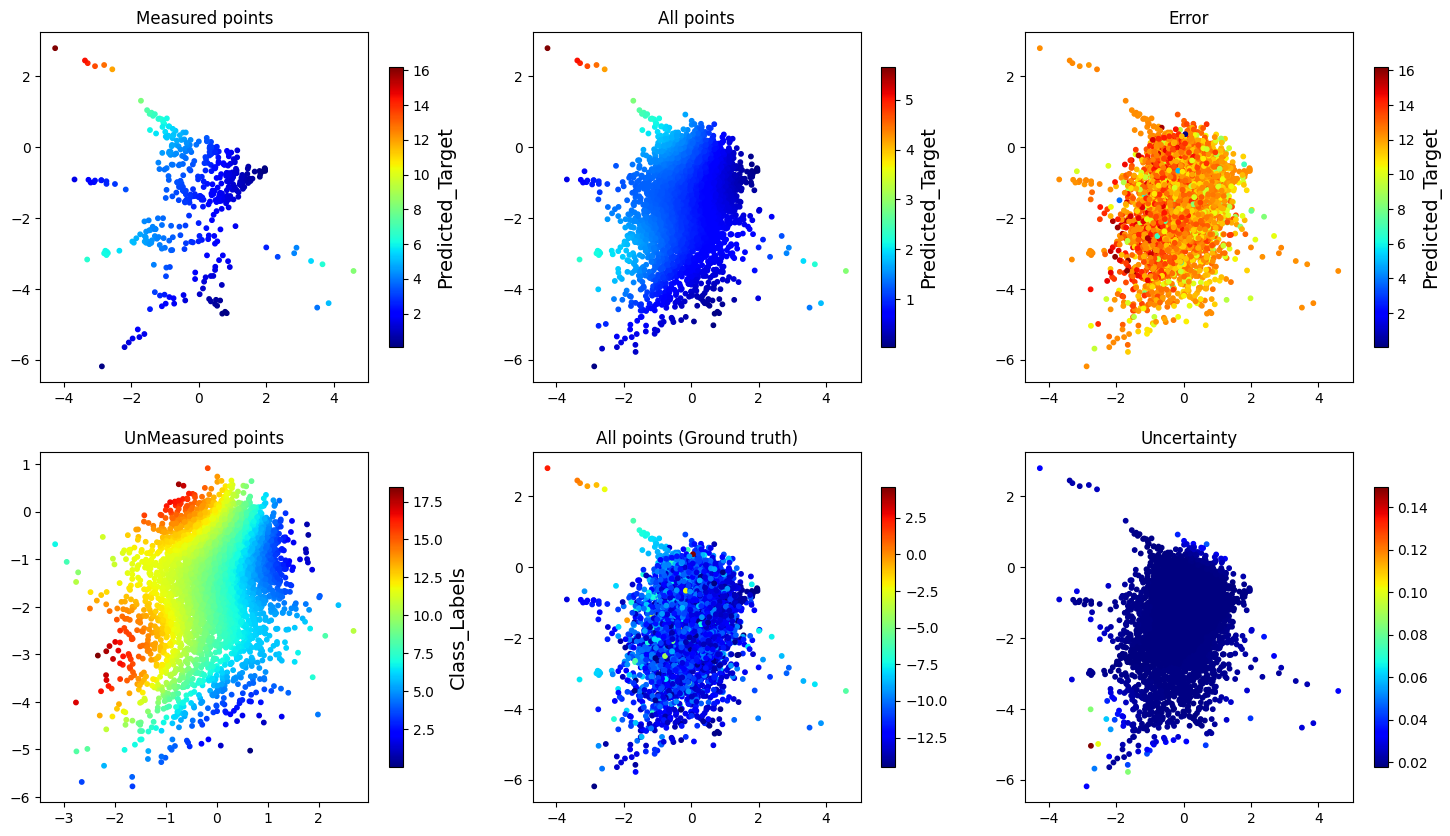

In [43]:
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,10))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10,
                c = predmean_unmeas5, cmap = 'jet')
ax[1,0].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15, cmap = 'jet')
ax[0,1].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = targets5, cmap = 'jet')
ax[1,1].set_title('All points (Ground truth)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15 - targets5, cmap = 'jet')
ax[0,2].set_title('Error')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
#cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predstd15, cmap = 'jet')
ax[1,2].set_title('Uncertainty')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
#cbar.set_label("Wt", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Exploration path

And now we have done it as active learning. Note that in this case the predicted targets form two regions in latent space. So, th elatent distirbution is much better behaved then for VAE, but not as good as for the full DKL. Still, we learned only with 1% of the data.

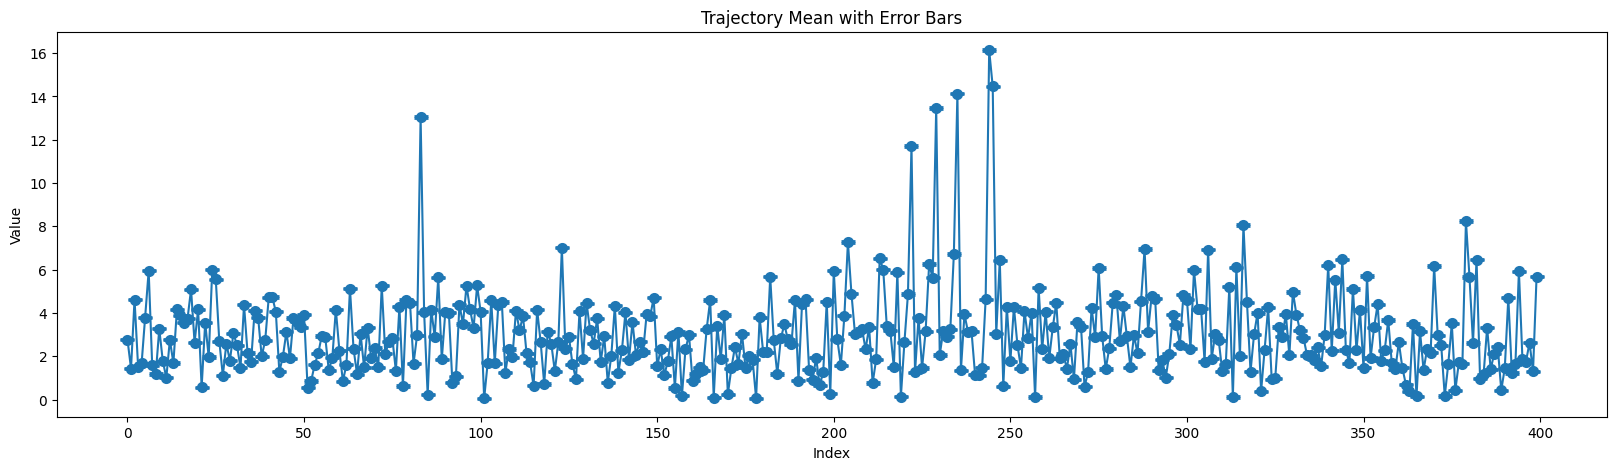

In [44]:
num_t = len(traj_mean5)
x = np.arange(traj_mean5[num_t-1].shape[0])

# Plotting the mean with error bars
fig, _ = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 5))
plt.errorbar(x, traj_mean5[num_t-1], yerr=traj_std5[num_t-1], fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Trajectory Mean with Error Bars')
plt.show()

In [45]:
original_array = np.array(one_hot_vectors).reshape(-1, s2*s3)
search_array = X5_train

import numpy as np

# Sample data (replace with your actual data)
# original_array = np.random.rand(5000, p)  # Original array of shape (5000, p)
# search_array = np.random.rand(m, p)       # Search array of shape (m, p)

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

# Find indices
indices = find_indices(original_array, search_array)

print(indices)

[3736 3417 1936  866 3663 4111 1239 3162 1419 3502 4213 1738 3485 3266
 1718  453  142 1531 1540 1888 2507 3410 4759 4577 3656 2888 3479 3955
 3894 4042 4840 3824 1237 4175  134 2013 2899 2806 4867 1497 1784 2447
 3427 1091 1224 4020 4486 3169  298 2924  601 4798 4258 1870 2864 4294
 2450 2612 1564 1900 4547 1272 2816 2078 3864 2234  608 3614  683 3540
 1248 2991 1281 2518 3857 2517 2448 3993  113 4866 2869 4843  381 4733
 2089 2345 2952 1014 3076  530  895 4912  491  872  138 1826 2164 1946
 1414 4771  159 4138 4536 4927 4573 1411 3597 4506 1085 2243 2459 2959
  727 2591 3643 4516 2670  499  979 3888 2460 3767 2396 3442  898 1977
 4076 3259 2149 4829 3798 1363  148 2072 3522 2033 3652 2661 1606 4752
 4146 1875 1990 4311 3170   42  533 2407 4463 3785  882  843 3081 3055
 2455 2882 1680 2769 2451 2571 4936 2263 2658 4925 1715 4235   49  556
  137 2907 2242  666   12 4865 2625  873 4159  130  651   30 2715 3195
 3043  202  716  991 2383 2377 2178 1065 1708 2984  678 4107 2802 2809
 4459 

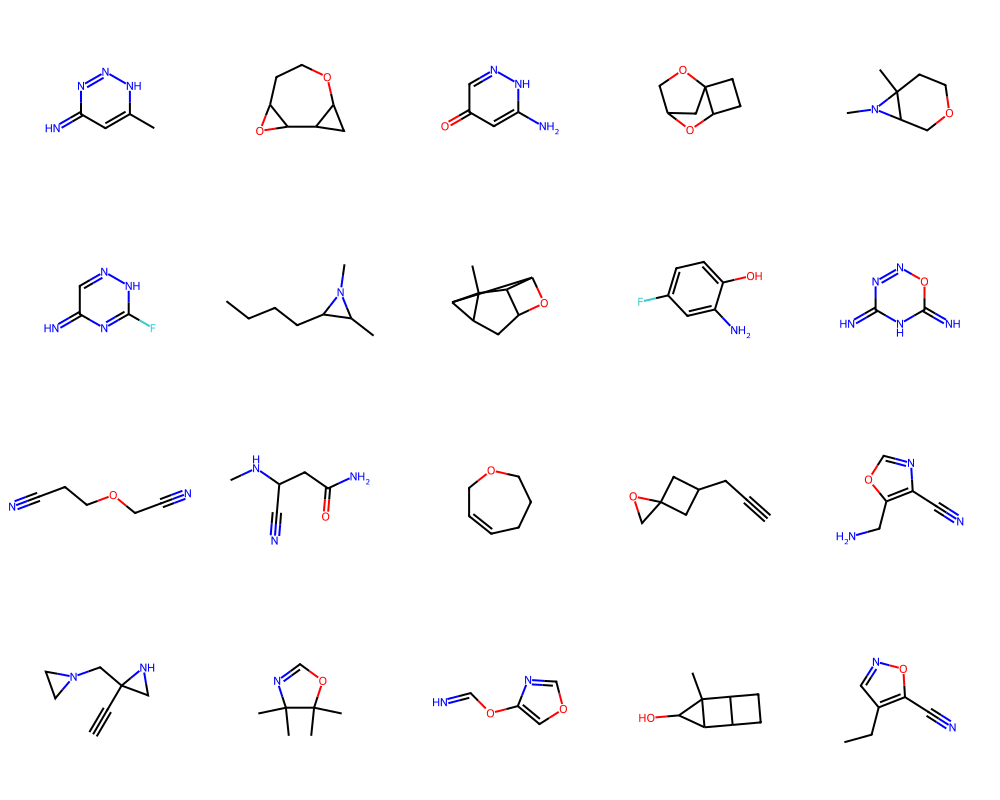

In [46]:
# Using the find_indices function from the previous response
indices_all = find_indices(original_array, search_array)
indices = indices_all[-20:]

# Filter out -1 (not found) indices
valid_indices = [index for index in indices if index != -1]

# Retrieve the corresponding rows in the DataFrame
corresponding_rows = df_filtered.iloc[valid_indices]

# Extract SMILES strings
smiles_list = corresponding_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(200, 200), useSVG=True)
img

# DKL on molecules (5D latent space)

In [47]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X5 = np.asarray(molecules).reshape([-1,s2*s3])
print(X5.shape)

#Actual target
targets5 = df_filtered['dipole_moment'].values

(4996, 567)


In [48]:
rng_key_5D, rng_key_predict_5D = gpax.utils.get_keys()
dkl_5D = gpax.viDKL(s2*s3, 5, 'RBF')
dkl_5D.fit(rng_key_5D, X5, targets5)

100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s, init loss: 52123.2356, avg. loss [951-1000]: 38021.2608]



Inferred GP kernel parameters
k_length         [1.6316 2.0225 2.1719 2.3678 2.4737]
k_scale          6.4891000000000005
noise            0.0335


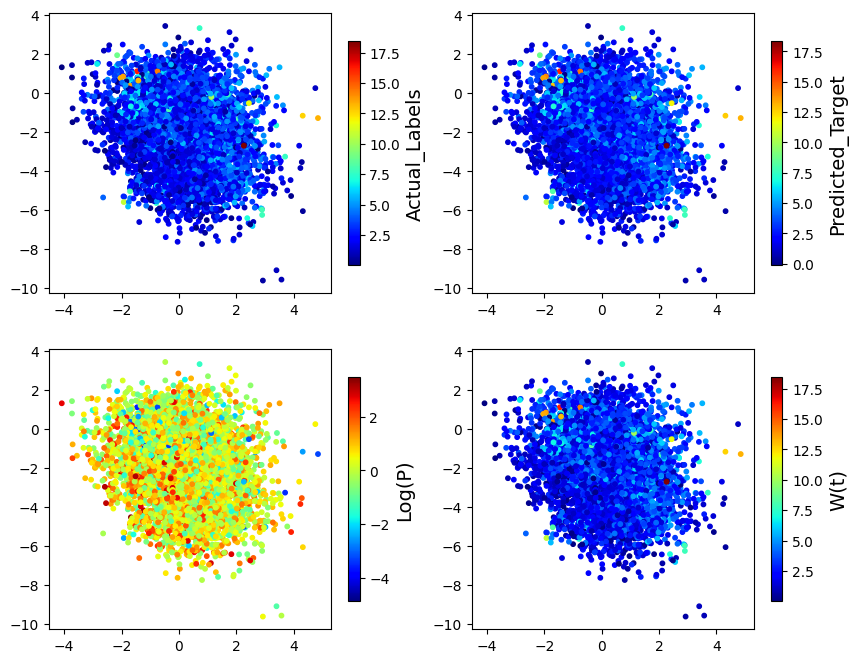

In [49]:
embeded_5D = dkl_5D.embed(X5)
pred_mean5D, pred_var5D = dkl_5D.predict_in_batches(rng_key_predict_5D, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5D)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = targets5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = pred_mean5D, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = df_filtered['mole_logp'].values,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = df_filtered['dipole_moment'].values, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("W(t)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [50]:
pred_mean5D.shape, pred_var5D.shape, embeded_5D.shape

((4996,), (4996,), (4996, 5))

In [51]:
from sklearn.manifold import TSNE

# Use t-SNE to project the data to 2D
tsne = TSNE(n_components=2, random_state=0)
embeded_2D = tsne.fit_transform(embeded_5D)

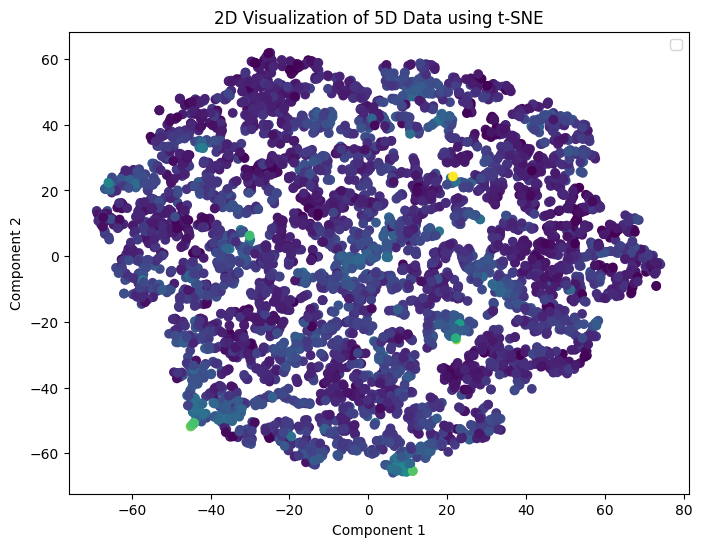

In [52]:
# Plot the projected data
plt.figure(figsize=(8, 6))
plt.scatter(embeded_2D[:, 0], embeded_2D[:, 1], c = targets5)
plt.legend()
plt.title('2D Visualization of 5D Data using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [53]:
!pip install requests

In [54]:
import requests

def query_pubchem(compound_name):
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    url = f"{base_url}/compound/name/{compound_name}/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Example usage
compound_info = query_pubchem("Aspirin")
if compound_info:
    print(compound_info)
else:
    print("Compound not found or error in request.")

{'PC_Compounds': [{'id': {'id': {'cid': 2244}}, 'atoms': {'aid': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'element': [8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1]}, 'bonds': {'aid1': [1, 1, 2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 12, 13, 13, 13], 'aid2': [5, 12, 11, 21, 11, 12, 6, 7, 8, 11, 9, 14, 10, 15, 10, 16, 17, 13, 18, 19, 20], 'order': [1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]}, 'coords': [{'type': [1, 5, 255], 'aid': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'conformers': [{'x': [3.732, 6.3301, 4.5981, 2.866, 4.5981, 5.4641, 4.5981, 6.3301, 5.4641, 6.3301, 5.4641, 2.866, 2, 4.0611, 6.8671, 5.4641, 6.8671, 2.31, 1.4631, 1.69, 6.3301], 'y': [-0.06, 1.44, 1.44, -1.56, -0.56, -0.06, -1.56, -0.56, -2.06, -1.56, 0.94, -0.56, -0.06, -1.87, -0.25, -2.68, -1.87, 0.4769, 0.25, -0.5969, 2.06], 'style': {'annotation': [8, 8, 8, 8, 8, 8], 'aid1': [5, 5, 6, 7, 8, 9], 'aid2': [

In [55]:
compound_info['PC_Compounds']


[{'id': {'id': {'cid': 2244}},
  'atoms': {'aid': [1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21],
   'element': [8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1]},
  'bonds': {'aid1': [1,
    1,
    2,
    2,
    3,
    4,
    5,
    5,
    6,
    6,
    7,
    7,
    8,
    8,
    9,
    9,
    10,
    12,
    13,
    13,
    13],
   'aid2': [5,
    12,
    11,
    21,
    11,
    12,
    6,
    7,
    8,
    11,
    9,
    14,
    10,
    15,
    10,
    16,
    17,
    13,
    18,
    19,
    20],
   'order': [1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]},
  'coords': [{'type': [1, 5, 255],
    'aid': [1,
     2,
     3,
     4,
     5,
     6,
     7,
     8,
     9,
     10,
     11,
     12,
     13,
     14,
     15,
     16,
     17,
     18,
     19,
     20,
     21],
    'conformers': [{'x': [3.732,
       6.3301,
       4.5981,
       